<img align="right" style="max-width: 200px; height: auto" src="hsg_logo.png">

###  Lab 06 - "Deep Learning - Convolutional Neural Networks"

Introduction to AI and ML, University of St. Gallen, Spring Term 2020

In the last lab you learned about how to utilize a **supervised** (deep) machine learning technique namely **Artificial Neural Networks (ANNs)** to classify tiny images of handwritten digits contained in the MNIST dataset. 

In this lab, we will learn how to enhance ANNs using PyTorch to classify even more complex images. Therefore, we use a special type of deep neural network referred to **Convolutional Neural Networks (CNNs)**. CNNs encompass the ability to take advantage of the hierarchical pattern in data and assemble more complex patterns using smaller and simpler patterns. Therefore, CNNs are capable to learn a set of discriminative features 'pattern' and subsequently utilize the learned pattern to classify the content of an image.

We will again use the functionality of the `PyTorch` library to implement and train an CNN based neural network. The network will be trained on a set of tiny images to learn a model of the image content. Upon successful training, we will utilize the learned CNN model to classify so far unseen tiny images into distinct categories such as aeroplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 

The figure below illustrates a high-level view on the machine learning process we aim to establish in this lab.

<img align="center" style="max-width: 900px" src="classification.png">

(Image of the CNN architecture created via http://alexlenail.me/)

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

### Lab Objectives:

After today's lab, you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **Convolutional Neural Networks (CNNs)**.
> 2. Know how to **implement and to train a CNN** to learn a model of tiny image data.
> 3. Understand how to apply such a learned model to **classify images** images based on their content into distinct categories.
> 4. Know how to **interpret and visualize** the model's classification results.

### Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the `PyTorch`, `Numpy`, `Sklearn`, `Matplotlib`, `Seaborn` and a few utility libraries throughout this lab:

In [1]:
# import standard python libraries
import os, urllib, io
from datetime import datetime
import numpy as np

Import Python machine / deep learning libraries:

In [2]:
# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

Import the sklearn classification metrics:

In [3]:
# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Import Python plotting libraries:

In [4]:
# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Enable notebook matplotlib inline plotting:

In [5]:
%matplotlib inline

Create notebook folder structure to store the data as well as the trained neural network models:

In [6]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

Set a random `seed` value to obtain reproducable results:

In [7]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

Enable GPU computing by setting the `device` flag and init a `CUDA` seed:

In [8]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


Let's determine if we have access to a GPU provided by e.g. Google's COLab environment:

In [9]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


### 1. Dataset Download and Data Assessment

The **CIFAR-10 database** (**C**anadian **I**nstitute **F**or **A**dvanced **R**esearch) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The database is widely used to conduct computer vision research using machine learning and deep learning methods:

<img align="center" style="max-width: 500px; height: 500px" src="cifar10.png">

(Source: https://www.kaggle.com/c/cifar-10)

Further details on the dataset can be obtained via: *Krizhevsky, A., 2009. "Learning Multiple Layers of Features from Tiny Images",  
( https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf )."*

The CIFAR-10 database contains **60,000 color images** (50,000 training images and 10,000 validation images). The size of each image is 32 by 32 pixels. The collection of images encompasses 10 different classes that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Let's define the distinct classs for further analytics:

In [10]:
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Thereby the dataset contains 6,000 images for each of the ten classes. The CIFAR-10 is a straightforward dataset that can be used to teach a computer how to recognize objects in images.

Let's download, transform and inspect the training images of the dataset. Therefore, we first will define the directory we aim to store the training data:

In [11]:
train_path = './data/train_cifar10'

Now, let's download the training data accordingly:

In [12]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and transform training images
cifar10_train_data = torchvision.datasets.CIFAR10(root=train_path, train=True, transform=transf, download=True)

Files already downloaded and verified


Verify the volume of training images downloaded:

In [13]:
# get the length of the training data
len(cifar10_train_data)

50000

Furthermore, let's investigate a couple of the training images:

In [14]:
# set (random) image id
image_id = 1800

# retrieve image exhibiting the image id
cifar10_train_data[image_id]

(tensor([[[ 0.0118, -0.0039,  0.0118,  ...,  0.0353,  0.0353,  0.0275],
          [ 0.0039,  0.0039,  0.0118,  ...,  0.0275,  0.0275,  0.0196],
          [ 0.0196,  0.0039,  0.0196,  ...,  0.0431,  0.0353,  0.0353],
          ...,
          [-0.2000, -0.2627, -0.4745,  ...,  0.0510,  0.0353,  0.0275],
          [-0.1529, -0.2471, -0.3725,  ...,  0.0431,  0.0275,  0.0196],
          [-0.1373, -0.3725, -0.4902,  ...,  0.0275,  0.0196,  0.0118]],
 
         [[ 0.1922,  0.1765,  0.1922,  ...,  0.2000,  0.2000,  0.1922],
          [ 0.1922,  0.1843,  0.1922,  ...,  0.1922,  0.1922,  0.1843],
          [ 0.2000,  0.1843,  0.2000,  ...,  0.2078,  0.2000,  0.2000],
          ...,
          [-0.1137, -0.1843, -0.4667,  ...,  0.2314,  0.2157,  0.2078],
          [-0.0667, -0.1451, -0.3569,  ...,  0.2235,  0.2078,  0.2000],
          [-0.0588, -0.2471, -0.4588,  ...,  0.2078,  0.2000,  0.1922]],
 
         [[ 0.5451,  0.5216,  0.5373,  ...,  0.5529,  0.5529,  0.5451],
          [ 0.5373,  0.5216,

Ok, that doesn't seem easily interpretable ;) Let's first seperate the image from its label information:

In [15]:
cifar10_train_image, cifar10_train_label = cifar10_train_data[image_id]

Great, now we are able to visually inspect our sample image: 

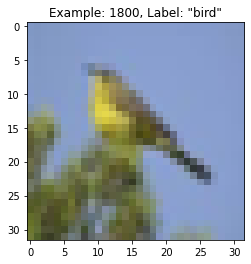

In [16]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: "{}"'.format(str(image_id), str(cifar10_classes[cifar10_train_label])))

# un-normalize cifar 10 image sample
cifar10_train_image_plot = cifar10_train_image / 2.0 + 0.5

# plot 10 image sample
plt.imshow(trans(cifar10_train_image_plot))

Fantastic, right? Let's now decide on where we want to store the evaluation data:

In [17]:
eval_path = './data/eval_cifar10'

And download the evaluation data accordingly:

In [18]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and transform validation images
cifar10_eval_data = torchvision.datasets.CIFAR10(root=eval_path, train=False, transform=transf, download=True)

Files already downloaded and verified


Verify the volume of validation images downloaded:

In [19]:
# get the length of the training data
len(cifar10_eval_data)

10000

### 2. Neural Network Implementation

In this section we, will implement the architecture of the **neural network** we aim to utilize to learn a model that is capable of classifying the 32x32 pixel CIFAR 10 images according to the objects contained in each image. However, before we start the implementation, let's briefly revisit the process to be established. The following cartoon provides a birds-eye view:

<img align="center" style="max-width: 900px" src="process.png">

Our CNN, which we name 'CIFAR10Net' and aim to implement consists of two **convolutional layers** and three **fully-connected layers**. In general, convolutional layers are specifically designed to learn a set of **high-level features** ("patterns") in the processed images, e.g., tiny edges and shapes. The fully-connected layers utilize the learned features to learn **non-linear feature combinations** that allow for highly accurate classification of the image content into the different image classes of the CIFAR-10 dataset, such as, birds, aeroplanes, horses.

Let's implement the network architecture and subsequently have a more in-depth look into its architectural details:

In [20]:
# implement the CIFAR10Net network architecture
class CIFAR10Net(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(CIFAR10Net, self).__init__()
        
        # specify convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        
        # define max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # specify convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        
        # define max-pooling layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # specify fc layer 1 - in 16 * 5 * 5, out 120
        self.linear1 = nn.Linear(16 * 5 * 5, 120, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity
        
        # specify fc layer 2 - in 120, out 84
        self.linear2 = nn.Linear(120, 84, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 84, out 10
        self.linear3 = nn.Linear(84, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # high-level feature learning via convolutional layers
        
        # define conv layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))
        
        # define conv layer 2 forward pass
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # feature flattening
        
        # reshape image pixels
        x = x.view(-1, 16 * 5 * 5)
        
        # combination of feature learning via non-linear layers
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))
        
        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))
        
        # return forward pass result
        return x

You may have noticed that we applied two more layers (compared to the MNIST example described in the last lab) before the fully-connected layers. These layers are referred to as **convolutional** layers and are usually comprised of three operations, (1) **convolution**, (2) **non-linearity**, and (3) **max-pooling**. Those operations are usually executed in sequential order during the forward pass through a convolutional layer.

In the following, we will have a detailed look into the functionality and number of parameters in each layer. We will start with providing images of 3x32x32 dimensions to the network, i.e., the three channels (red, green, blue) of an image each of size 32x32 pixels.

#### 2.1. High-Level Feature Learning by Convolutional Layers

Let's first have a look into the convolutional layers of the network as illustrated in the following:

<img align="center" style="max-width: 600px" src="convolutions.png">

**First Convolutional Layer**: The first convolutional layer expects three input channels and will convolve six filters each of size 3x5x5. Let's briefly revisit how we can perform a convolutional operation on a given image. For that, we need to define a kernel which is a matrix of size 5x5, for example. To perform the convolution operation, we slide the kernel along with the image horizontally and vertically and obtain the dot product of the kernel and the pixel values of the image inside the kernel ('receptive field' of the kernel).

The following illustration shows an example of a discrete convolution:

<img align="center" style="max-width: 800px" src="convsample.png">

The left grid is called the input (an image or feature map). The middle grid, referred to as kernel, slides across the input feature map (or image). At each location, the product between each element of the kernel and the input element it overlaps is computed, and the results are summed up to obtain the output in the current location. In general, a discrete convolution is mathematically expressed by:

<center> $y(m, n) = x(m, n) * h(m, n) = \sum^{m}_{j=0} \sum^{n}_{i=0} x(i, j) * h(m-i, n-j)$, </center>

where $x$ denotes the input image or feature map, $h$ the applied kernel, and, $y$ the output.

When performing the convolution operation the 'stride' defines the number of pixels to pass at a time when sliding the kernel over the input. While 'padding' adds the number of pixels to the input image (or feature map) to ensure that the output has the same shape as the input. Let's have a look at another animated example:

<img align="center" style="max-width: 800px" src="convsample_animated.gif">

(Source: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

In our implementation padding is set to 0 and stride is set to 1. As a result, the output size of the convolutional layer becomes 6x28x28, because (32 - 5) + 1 = 28. This layer exhibits ((5 x 5 x 3) + 1) x 6 = 456 parameter. 

**First Max-Pooling Layer:** The max-pooling process is a sample-based discretization operation. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.

To conduct such an operation, we again need to define a kernel. Max-pooling kernels are usually a tiny matrix of, e.g, of size 2x2. To perform the max-pooling operation, we slide the kernel along the image horizontally and vertically (similarly to a convolution) and compute the maximum pixel value of the image (or feature map) inside the kernel (the receptive field of the kernel).

The following illustration shows an example of a max-pooling operation:

<img align="center" style="max-width: 500px" src="poolsample.png">

The left grid is called the input (an image or feature map). The middle grid, referred to as kernel, slides across the input feature map (or image). We use a stride of 2, meaning the step distance for stepping over our input will be 2 pixels and won't overlap regions. At each location, the max value of the region that overlaps with the elements of the kernel and the input elements it overlaps is computed, and the results are obtained in the output of the current location.

In our implementation, we do max-pooling with a 2x2 kernel and stride 2 this effectively drops the original image size from 6x28x28 to 6x14x14. Let's have a look at an exemplary visualization of 64 features learnt in the first convolutional layer on the CIFAR- 10 dataset.

<img align="center" style="max-width: 600px" src="cnnfeatures.png">

(Source: Yu, Dingjun, Hanli Wang, Peiqiu Chen, and Zhihua Wei. **"Mixed pooling for convolutional neural networks."** In International conference on rough sets and knowledge technology, pp. 364-375. Springer, Cham, 2014)

**Second Convolutional Layer:** The second convolutional layer expects 6 input channels and will convolve 16 filters each of size 6x5x5x. Since padding is set to 0 and stride is set 1, the output size is 16x10x10, because (14  - 5) + 1 = 10. This layer therefore has ((5 x 5 x 6) + 1 x 16) = 24,16 parameter.

**Second Max-Pooling Layer:** The second down-sampling layer uses max-pooling with 2x2 kernel and stride set to 2. This effectively drops the size from 16x10x10 to 16x5x5. 

#### 2.2. Feature Flattening

The output of the final-max pooling layer needs to be flattened so that we can connect it to a fully connected layer. This is achieved using the `torch.Tensor.view` method. Setting the parameter of the method to `-1` will automatically infer the number of rows required to handle the mini-batch size of the data. 

#### 2.3. Learning of Feature Combinations

Let's now have a look into the non-linear layers of the network illustrated in the following:

<img align="center" style="max-width: 600px" src="fullyconnected.png">

The first fully connected layer uses 'Rectified Linear Units' (ReLU) activation functions to learn potential nonlinear combinations of features. The layers are implemented similarly to the fifth lab. Therefore, we will only focus on the number of parameters of each fully-connected layer:

**First Fully-Connected Layer:** The first fully-connected layer consists of 120 neurons, thus in total exhibits ((16 x 5 x 5) + 1) x 120 = 48,120 parameter. 

**Second Fully-Connected Layer:** The output of the first fully-connected layer is then transferred to second fully-connected layer. The layer consists of 84 neurons equipped with ReLu activation functions, this in total exhibits (120 + 1) x 84 = 10,164 parameter.

The output of the second fully-connected layer is then transferred to the output-layer (third fully-connected layer). The output layer is equipped with a softmax (that you learned about in the previous lab 05) and is made up of ten neurons, one for each object class contained in the CIFAR-10 dataset. This layer exhibits (84 + 1) x 10 = 850 parameter.


As a result our CIFAR-10 convolutional neural exhibits a total of 456 + 2,416 + 48,120 + 10,164 + 850 = 62,006 parameter.

(Source: https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/)

Now, that we have implemented our first Convolutional Neural Network we are ready to instantiate a network model to be trained:

In [21]:
model = CIFAR10Net()

Let's push the initialized `CIFAR10Net` model to the computing `device` that is enabled:

In [22]:
model = model.to(device)

Let's double check if our model was deployed to the GPU if available:

In [23]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [24]:
# print the initialized architectures
print('[LOG] CIFAR10Net architecture:\n\n{}\n'.format(model))

[LOG] CIFAR10Net architecture:

CIFAR10Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)



Looks like intended? Brilliant! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [25]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained CIFAR10Net model parameters: {}.'.format(num_params))

[LOG] Number of to be trained CIFAR10Net model parameters: 62006.


Ok, our "simple" CIFAR10Net model already encompasses an impressive number 62'006 model parameters to be trained.

Now that we have implemented the CIFAR10Net, we are ready to train the network. However, before starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the classification error of the true class $c^{i}$ of a given CIFAR-10 image $x^{i}$ and its predicted class $\hat{c}^{i} = f_\theta(x^{i})$ as faithfully as possible. 

In this lab we use (similarly to lab 05) the **'Negative Log-Likelihood (NLL)'** loss. During training the NLL loss will penalize models that result in a high classification error between the predicted class labels $\hat{c}^{i}$ and their respective true class label $c^{i}$. Now that we have implemented the CIFAR10Net, we are ready to train the network. Before starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the classification error of the true class $c^{i}$ of a given CIFAR-10 image $x^{i}$ and its predicted class $\hat{c}^{i} = f_\theta(x^{i})$ as faithfully as possible. 

Let's instantiate the NLL via the execution of the following PyTorch command:

In [26]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

Let's also push the initialized `nll_loss` computation to the computing `device` that is enabled:

In [27]:
nll_loss = nll_loss.to(device)

Based on the loss magnitude of a certain mini-batch PyTorch automatically computes the gradients. But even better, based on the gradient, the library also helps us in the optimization and update of the network parameters $\theta$.

We will use the **Stochastic Gradient Descent (SGD) optimization** and set the `learning-rate to 0.001`. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error (the NLL loss).

In [28]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

Now that we have successfully implemented and defined the three CNN building blocks let's take some time to review the `CIFAR10Net` model definition as well as the `loss`. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

### 3. Training the Neural Network Model

In this section, we will train our neural network model (as implemented in the section above) using the transformed images. More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

#### 3.1. Preparing the Network Training

So far, we have pre-processed the dataset, implemented the CNN and defined the classification error. Let's now start to train a corresponding model for **20 epochs** and a **mini-batch size of 128** CIFAR-10 images per batch. This implies that the whole dataset will be fed to the CNN 20 times in chunks of 4 images yielding to **12,500 mini-batches** (50.000 training images / 4 images per mini-batch) per epoch. After the processing of each mini-batch, the parameters of the network will be updated. 

In [29]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 4 # size of the mini-batches

Furthermore, lets specifiy and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [30]:
cifar10_train_dataloader = torch.utils.data.DataLoader(cifar10_train_data, batch_size=mini_batch_size, shuffle=True)

#### 3.2. Running the Network Training

Finally, we start training the model. The training procedure for each mini-batch is performed as follows: 

>1. do a forward pass through the CIFAR10Net network, 
>2. compute the negative log-likelihood classification error $\mathcal{L}^{NLL}_{\theta}(c^{i};\hat{c}^{i})$, 
>3. do a backward pass through the CIFAR10Net network, and 
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training our CNN model, we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the classification performance of the entire training dataset after each training epoch. Based on this evaluation, we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:
 
>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [31]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the CIFAR10 model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(cifar10_train_dataloader):
        
        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        
        # determine classification loss
        loss = nll_loss(output, labels)
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'cifar10_model_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20200511-10:03:33] epoch: 0 train-loss: 2.238219862680435
[LOG 20200511-10:04:12] epoch: 1 train-loss: 1.935777970509529
[LOG 20200511-10:04:45] epoch: 2 train-loss: 1.684436317577362
[LOG 20200511-10:05:17] epoch: 3 train-loss: 1.5414427460861206
[LOG 20200511-10:05:47] epoch: 4 train-loss: 1.4574027087664605
[LOG 20200511-10:06:17] epoch: 5 train-loss: 1.3850340257668494
[LOG 20200511-10:06:48] epoch: 6 train-loss: 1.3218666888189317
[LOG 20200511-10:07:17] epoch: 7 train-loss: 1.265575843114853
[LOG 20200511-10:07:47] epoch: 8 train-loss: 1.2157743350499868
[LOG 20200511-10:08:15] epoch: 9 train-loss: 1.1745015937310457
[LOG 20200511-10:08:42] epoch: 10 train-loss: 1.135681571468711
[LOG 20200511-10:09:12] epoch: 11 train-loss: 1.0998355753684044
[LOG 20200511-10:09:39] epoch: 12 train-loss: 1.0676548833155632
[LOG 20200511-10:10:09] epoch: 13 train-loss: 1.0361538963371515
[LOG 20200511-10:10:40] epoch: 14 train-loss: 1.0077817464274168
[LOG 20200511-10:11:10] epoch: 15 train-

Upon successfull training let's visualize and inspect the training loss per epoch:

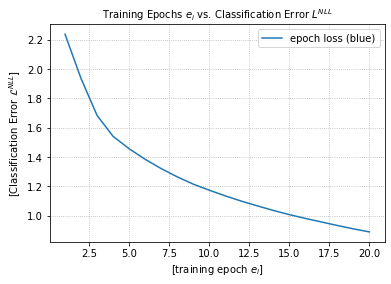

In [32]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Ok, fantastic. The training error converges nicely. We could definitely train the network a couple more epochs until the error converges. But let's stay with the 20 training epochs for now and continue with evaluating our trained model.

### 4. Evaluation of the Trained Neural Network Model

Prior to evaluating our model, let's load the best performing model. Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load the last snapshot saved.

In [33]:
# restore pre-trained model snapshot
best_model_name = "cifar10_model_epoch_19.pth"

# init pre-trained model class
best_model = CIFAR10Net()

# load pre-trained models
best_model.load_state_dict(torch.load(os.path.join("models", best_model_name), map_location=torch.device('cpu')))

<All keys matched successfully>

Let's inspect if the model was loaded successfully: 

In [34]:
# set model in evaluation mode
best_model.eval()

CIFAR10Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)

In order to evaluate our trained model, we need to feed the CIFAR10 images reserved for evaluation (the images that we didn't use as part of the training process) through the model. Therefore, let's again define a corresponding PyTorch data loader that feeds the image tensors to our neural network: 

In [35]:
cifar10_eval_dataloader = torch.utils.data.DataLoader(cifar10_eval_data, batch_size=10000, shuffle=False)

We will now evaluate the trained model using the same mini-batch approach as we did when training the network and derive the mean negative log-likelihood loss of all mini-batches processed in an epoch:

In [36]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(cifar10_eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20200511-10:13:20] eval-loss: 1.0348503589630127


Ok, great. The evaluation loss looks in-line with our training loss. Let's now inspect a few sample predictions to get an impression of the model quality. Therefore, we will again pick a random image of our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:

In [37]:
# set (random) image id
image_id = 777

# retrieve image exhibiting the image id
cifar10_eval_image, cifar10_eval_label = cifar10_eval_data[image_id]

Let's now inspect the true class of the image we selected:

In [38]:
cifar10_classes[cifar10_eval_label]

'frog'

Ok, the randomly selected image should contain a two (2). Let's inspect the image accordingly:

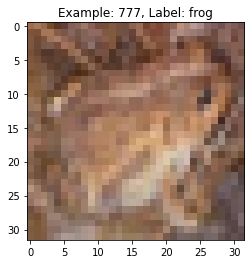

In [39]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), str(cifar10_classes[cifar10_eval_label])))

# un-normalize cifar 10 image sample
cifar10_eval_image_plot = cifar10_eval_image / 2.0 + 0.5

# plot cifar 10 image sample
plt.imshow(trans(cifar10_eval_image_plot))

Ok, let's compare the true label with the prediction of our model:

In [40]:
best_model(cifar10_eval_image.unsqueeze(0))

tensor([[ -8.7498, -11.1383,  -3.6063,  -1.7705,  -3.3294,  -2.5025,  -0.3873,
          -5.1666,  -9.0390, -10.6598]], grad_fn=<LogSoftmaxBackward>)

We can even determine the likelihood of the most probable class:

In [41]:
cifar10_classes[torch.argmax(best_model(Variable(cifar10_eval_image.unsqueeze(0))), dim=1).item()]

'frog'

Let's now obtain the predictions for all the CIFAR-10 images of the evaluation data:

In [42]:
predictions = torch.argmax(best_model(iter(cifar10_eval_dataloader).next()[0]), dim=1)

Furthermore, let's obtain the overall classification accuracy:

In [43]:
metrics.accuracy_score(cifar10_eval_data.targets, predictions.detach())

0.6437

Let's also inspect the confusion matrix of the model predictions to determine major sources of misclassification:

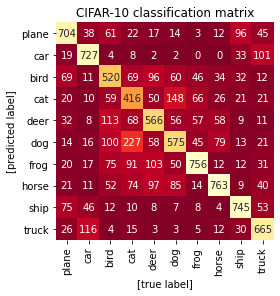

In [44]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(cifar10_eval_data.targets, predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title('CIFAR-10 classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Ok, we can easily see that our current model confuses images of cats and dogs as well as images of trucks and cars quite often. This is again not surprising since those image categories exhibit a high semantic and therefore visual similarity.

### Exercises:

We recommend you try the following exercises as part of the lab:

**1. Train the network a couple more epochs and evaluate its prediction accuracy.**

> Increase the number of training epochs up to 50 epochs and re-run the network training. Load and evaluate the model exhibiting the lowest training loss. What kind of behavior in terms of prediction accuracy can be observed with increasing the training epochs?

In [45]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**2. Evaluation of "shallow" vs. "deep" neural network architectures.**

> In addition to the architecture of the lab notebook, evaluate further (more shallow as well as more deep) neural network architectures by (1) either removing or adding layers to the network and/or (2) increasing/decreasing the number of neurons per layer. Train a model (using the architectures you selected) for at least 50 training epochs. Analyze the prediction performance of the trained models in terms of training time and prediction accuracy. 

In [46]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

### 5. [Bonus]: Deep Residual Learning 'ResNet' Architecture

Deep neural networks have led to a series of breakthroughs for image classification. In general, deep networks naturally integrate low/mid/high-level features and classifiers in an end-to-end multilayer fashion, and the 'levels' of features can be enriched by the depth (or number of stacked layers) of the network. Driven by the significance of depth, the question arises: **Will stacking more layers improve feature learning and therefore increase the classification capability of a model?**

In 2015, in their work **'Deep Residual Learning for Image Recognition'** He et al. (https://arxiv.org/abs/1512.03385) proposed an enhanced deep convolutional neural network architecture. The architecture is referred to as **Residual Neural Networks** since it encompasses so called **Residual Layers** or **Residual Blocks**. Using the architecture He et al. demonstrated that they were able to outperform a variety of image classification benchmark challanges at the time. We have a closer look into the distinct characteristic of the architecture on the following section of the notebook.

#### 5.1. Implementation of the "ResNet" Architecture

In general, a **residual block** simply denotes that the activation of a layer can be fast-forwarded to a deeper layer in the neural network. As you can observe in the image below, the activation from a previous layer is being added to the final activation of a deeper layer in the network.

<img align="center" style="max-width: 400px" src="residualblock.png">

(Source: 'Deep Residual Learning for Image Recognition', He, K., Zhang, X., Ren, S., and, Sun, J., 2015)

Let's implement such a **Residual Block**, as shown above, using `PyTorch`library: 

In [47]:
# implement ResNet residual block
class ResidualBlock(nn.Module):

    # define the class constructor
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):

        # call super class constructor
        super(ResidualBlock, self).__init__()

        # init first convolutional layer of residual block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) # batch-normalization
        self.relu1 = nn.ReLU(inplace=True) # non-linearity
        
        # init second convolutional layer of residual block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) # batch-normalization
        self.relu2 = nn.ReLU(inplace=True) # non-linearity
        
        # init down-sample flag
        self.downsample = downsample

    # define the block forward pass
    def forward(self, x):

        # determine residual
        residual = x
        
        # case: down-sampling needed
        if self.downsample:
            
            # determine down-sampled residual
            residual = self.downsample(residual)

        # run forward pass through first layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # run forward pass through second layer
        out = self.conv2(out)
        out = self.bn2(out)

        # merge output and residual
        # the skip connection :) 
        out += residual
        
        # run second non-linearity
        out = self.relu2(out)

        # return residual block output
        return out

Let's implement a `ResNet` network architecture and subsequently have a more in-depth look into its architectural details:

In [48]:
# implement the ResNet architecture
class ResNet(nn.Module):

    # define the class constructor
    def __init__(self, layers):
        
        # call super class constructor
        super(ResNet, self).__init__()
        
        #### feature learning layers

        # init initial convolutional layer
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16) # batch-normalization
        self.relu = nn.ReLU(inplace=True) # non-linearity

        # init first residual layer 
        self.layer1 = self.make_residual_layer(in_channels=16, out_channels=16, blocks=layers[0], stride=1)
        
        # init second residual layer 
        self.layer2 = self.make_residual_layer(in_channels=16, out_channels=32, blocks=layers[1], stride=1)
        
        # init third residual layer 
        self.layer3 = self.make_residual_layer(in_channels=32, out_channels=64, blocks=layers[2], stride=1)

        # init average pooling
        self.avg_pool = nn.AvgPool2d(8)

        #### feature classification layers
        
        # define fully connected layer 
        self.fc = nn.Linear(1024, 10)

        # define log-softmax probability conversion
        self.logsoftmax = nn.LogSoftmax(dim=1)

    # create residual layer 
    def make_residual_layer(self, in_channels, out_channels, blocks, stride=1):

        # init down-sample flag
        downsample = None

        # init array of residual layer elements 
        layers = []
        
        # case: down sampling needed
        if in_channels != out_channels:

            # init down-sampling layer 
            downsample = nn.Sequential(
                
                # init down-sampling convolution
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                
                # init down-sampling batch normalization 
                nn.BatchNorm2d(out_channels)
            )
        
        # init and append initial residual block
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))

        # reset input channels
        self.in_channels = out_channels

        # iterate over remaining residual blocks
        for i in range(1, blocks):

            # init and append remaining residual blocks
            layers.append(ResidualBlock(out_channels, out_channels))

        # stack layers 
        residual_layer = nn.Sequential(*layers)
        
        # return residual layer 
        return residual_layer

    # define the network forward pass
    def forward(self, x):

        # run through inital convolution
        x = self.conv(x)
        
        # run through initial batch-normalization
        x = self.bn(x)
        
        # run trough first residual block
        x = self.layer1(x)
        
        # run through second residual block
        x = self.layer2(x)
        
        # run through third residual block
        x = self.layer3(x)
        
        # conduct average pooling of learned features
        x = self.avg_pool(x)
        
        # reshape the feature map
        x = x.view(x.size(0), -1)
        
        # run final fully-connected layer
        x = self.fc(x)
        
        # run final log-softmax
        x = self.logsoftmax(x)

        # return forward pass result
        return x

Now, that we have implemented our `ResNet` architecture we are ready to instantiate a network model to be trained. In the following we instantiate a `ResNet` where each residual layer consists of two residual blocks: 

In [49]:
resnet_model = ResNet(layers=[2, 2, 2])

Let's push the initialized `ResNet` model to the computing `device` that is enabled:

In [50]:
resnet_model = resnet_model.to(device)

Let's double check if our model was deployed to the GPU if available:

In [51]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [52]:
# print the initialized architectures
print('[LOG] ResNet architecture:\n\n{}\n'.format(resnet_model))

[LOG] ResNet architecture:

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(

Looks like intended? Brilliant! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [53]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in resnet_model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 205338.


Ok, our `ResNet` model encompasses a total of 205'338 model parameters to be trained. That's quite an increase in comparison to the prior `CIFAR10Net` that corresponded to 62'006 parameters. 

#### 5.2. Training of the "ResNet" Architecture

Similarly to training the `CIFAR10Net`, we will use the **Stochastic Gradient Descent (SGD) optimization** and set the `learning-rate to 0.001`. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error (the NLL loss).

In [54]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=resnet_model.parameters(), lr=learning_rate)

Let's now start to train a `ResNet`corresponding model for **20 epochs** and a **mini-batch size of 128** CIFAR-10 images per batch. This implies that the whole dataset will be fed to the architecture 20 times in chunks of 128 images yielding to **391 mini-batches** (50.000 training images / 128 images per mini-batch) per epoch. After the processing of each mini-batch, the parameters of the network will be updated. 

In [55]:
# specify the training parameters
num_epochs = 1 # 20 # number of training epochs

Let's conduct the model training accordingly:

In [ ]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
resnet_model.train()

# train the CIFAR10 model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(cifar10_train_dataloader):
        
        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # run forward pass through the network
        output = resnet_model(images)
        
        # reset graph gradients
        resnet_model.zero_grad()
        
        # determine classification loss
        loss = nll_loss(output, labels)
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
        
        # print mini-batch loss
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] epoch: {}, batch: {} train-loss: {}'.format(str(now), str(epoch), str(i), str(loss.item())))

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'cifar10_resnet_model_epoch_{}.pth'.format(str(epoch))
    torch.save(resnet_model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20200511-10:13:24] epoch: 0, batch: 0 train-loss: 2.3967509269714355
[LOG 20200511-10:13:24] epoch: 0, batch: 1 train-loss: 2.2354273796081543
[LOG 20200511-10:13:25] epoch: 0, batch: 2 train-loss: 2.248624801635742
[LOG 20200511-10:13:25] epoch: 0, batch: 3 train-loss: 2.09393572807312
[LOG 20200511-10:13:25] epoch: 0, batch: 4 train-loss: 2.1641650199890137
[LOG 20200511-10:13:25] epoch: 0, batch: 5 train-loss: 2.589729070663452
[LOG 20200511-10:13:25] epoch: 0, batch: 6 train-loss: 2.5136914253234863
[LOG 20200511-10:13:25] epoch: 0, batch: 7 train-loss: 2.273439407348633
[LOG 20200511-10:13:25] epoch: 0, batch: 8 train-loss: 2.1926562786102295
[LOG 20200511-10:13:26] epoch: 0, batch: 9 train-loss: 2.4222898483276367
[LOG 20200511-10:13:26] epoch: 0, batch: 10 train-loss: 2.6205220222473145
[LOG 20200511-10:13:26] epoch: 0, batch: 11 train-loss: 2.57287859916687
[LOG 20200511-10:13:26] epoch: 0, batch: 12 train-loss: 2.032496929168701
[LOG 20200511-10:13:26] epoch: 0, batch: 13

[LOG 20200511-10:13:39] epoch: 0, batch: 110 train-loss: 2.082285165786743
[LOG 20200511-10:13:40] epoch: 0, batch: 111 train-loss: 2.2324929237365723
[LOG 20200511-10:13:40] epoch: 0, batch: 112 train-loss: 2.0562384128570557
[LOG 20200511-10:13:40] epoch: 0, batch: 113 train-loss: 2.1778342723846436
[LOG 20200511-10:13:40] epoch: 0, batch: 114 train-loss: 2.3845648765563965
[LOG 20200511-10:13:40] epoch: 0, batch: 115 train-loss: 2.39973521232605
[LOG 20200511-10:13:40] epoch: 0, batch: 116 train-loss: 2.099135398864746
[LOG 20200511-10:13:40] epoch: 0, batch: 117 train-loss: 2.454850912094116
[LOG 20200511-10:13:41] epoch: 0, batch: 118 train-loss: 2.2798538208007812
[LOG 20200511-10:13:41] epoch: 0, batch: 119 train-loss: 2.2404897212982178
[LOG 20200511-10:13:41] epoch: 0, batch: 120 train-loss: 2.2159833908081055
[LOG 20200511-10:13:41] epoch: 0, batch: 121 train-loss: 2.111107587814331
[LOG 20200511-10:13:41] epoch: 0, batch: 122 train-loss: 2.2358360290527344
[LOG 20200511-10:1

[LOG 20200511-10:13:55] epoch: 0, batch: 219 train-loss: 1.8623781204223633
[LOG 20200511-10:13:56] epoch: 0, batch: 220 train-loss: 2.4086432456970215
[LOG 20200511-10:13:56] epoch: 0, batch: 221 train-loss: 2.1106925010681152
[LOG 20200511-10:13:56] epoch: 0, batch: 222 train-loss: 1.9180214405059814
[LOG 20200511-10:13:56] epoch: 0, batch: 223 train-loss: 2.1901516914367676
[LOG 20200511-10:13:56] epoch: 0, batch: 224 train-loss: 1.7667455673217773
[LOG 20200511-10:13:56] epoch: 0, batch: 225 train-loss: 2.0182852745056152
[LOG 20200511-10:13:56] epoch: 0, batch: 226 train-loss: 2.3178789615631104
[LOG 20200511-10:13:56] epoch: 0, batch: 227 train-loss: 2.246184825897217
[LOG 20200511-10:13:56] epoch: 0, batch: 228 train-loss: 1.8261213302612305
[LOG 20200511-10:13:57] epoch: 0, batch: 229 train-loss: 2.242708921432495
[LOG 20200511-10:13:57] epoch: 0, batch: 230 train-loss: 2.099839210510254
[LOG 20200511-10:13:57] epoch: 0, batch: 231 train-loss: 2.404082775115967
[LOG 20200511-10

[LOG 20200511-10:14:08] epoch: 0, batch: 328 train-loss: 2.062162399291992
[LOG 20200511-10:14:09] epoch: 0, batch: 329 train-loss: 1.6976137161254883
[LOG 20200511-10:14:09] epoch: 0, batch: 330 train-loss: 1.5029631853103638
[LOG 20200511-10:14:09] epoch: 0, batch: 331 train-loss: 2.1708076000213623
[LOG 20200511-10:14:09] epoch: 0, batch: 332 train-loss: 1.3247002363204956
[LOG 20200511-10:14:09] epoch: 0, batch: 333 train-loss: 1.7095024585723877
[LOG 20200511-10:14:09] epoch: 0, batch: 334 train-loss: 2.389310121536255
[LOG 20200511-10:14:09] epoch: 0, batch: 335 train-loss: 2.447578191757202
[LOG 20200511-10:14:09] epoch: 0, batch: 336 train-loss: 1.781511664390564
[LOG 20200511-10:14:09] epoch: 0, batch: 337 train-loss: 2.326540470123291
[LOG 20200511-10:14:09] epoch: 0, batch: 338 train-loss: 1.7733335494995117
[LOG 20200511-10:14:10] epoch: 0, batch: 339 train-loss: 1.7214717864990234
[LOG 20200511-10:14:10] epoch: 0, batch: 340 train-loss: 2.183126926422119
[LOG 20200511-10:1

[LOG 20200511-10:14:21] epoch: 0, batch: 438 train-loss: 2.3301100730895996
[LOG 20200511-10:14:21] epoch: 0, batch: 439 train-loss: 2.410452365875244
[LOG 20200511-10:14:21] epoch: 0, batch: 440 train-loss: 1.9257012605667114
[LOG 20200511-10:14:21] epoch: 0, batch: 441 train-loss: 2.4418230056762695
[LOG 20200511-10:14:21] epoch: 0, batch: 442 train-loss: 2.676530122756958
[LOG 20200511-10:14:21] epoch: 0, batch: 443 train-loss: 2.1054880619049072
[LOG 20200511-10:14:21] epoch: 0, batch: 444 train-loss: 1.86165189743042
[LOG 20200511-10:14:21] epoch: 0, batch: 445 train-loss: 2.0418810844421387
[LOG 20200511-10:14:22] epoch: 0, batch: 446 train-loss: 1.5347646474838257
[LOG 20200511-10:14:22] epoch: 0, batch: 447 train-loss: 2.2708351612091064
[LOG 20200511-10:14:22] epoch: 0, batch: 448 train-loss: 1.700238823890686
[LOG 20200511-10:14:22] epoch: 0, batch: 449 train-loss: 2.2042179107666016
[LOG 20200511-10:14:22] epoch: 0, batch: 450 train-loss: 1.8560807704925537
[LOG 20200511-10:

[LOG 20200511-10:14:33] epoch: 0, batch: 548 train-loss: 1.5949275493621826
[LOG 20200511-10:14:33] epoch: 0, batch: 549 train-loss: 1.8762493133544922
[LOG 20200511-10:14:34] epoch: 0, batch: 550 train-loss: 1.861290454864502
[LOG 20200511-10:14:34] epoch: 0, batch: 551 train-loss: 1.8065348863601685
[LOG 20200511-10:14:34] epoch: 0, batch: 552 train-loss: 1.8836753368377686
[LOG 20200511-10:14:34] epoch: 0, batch: 553 train-loss: 1.7727255821228027
[LOG 20200511-10:14:34] epoch: 0, batch: 554 train-loss: 1.509321689605713
[LOG 20200511-10:14:34] epoch: 0, batch: 555 train-loss: 1.2948853969573975
[LOG 20200511-10:14:34] epoch: 0, batch: 556 train-loss: 1.9343202114105225
[LOG 20200511-10:14:34] epoch: 0, batch: 557 train-loss: 1.7124494314193726
[LOG 20200511-10:14:34] epoch: 0, batch: 558 train-loss: 1.314255952835083
[LOG 20200511-10:14:35] epoch: 0, batch: 559 train-loss: 1.8049910068511963
[LOG 20200511-10:14:35] epoch: 0, batch: 560 train-loss: 1.9842805862426758
[LOG 20200511-1

[LOG 20200511-10:14:46] epoch: 0, batch: 658 train-loss: 1.9386107921600342
[LOG 20200511-10:14:46] epoch: 0, batch: 659 train-loss: 1.8448232412338257
[LOG 20200511-10:14:46] epoch: 0, batch: 660 train-loss: 2.6416406631469727
[LOG 20200511-10:14:46] epoch: 0, batch: 661 train-loss: 1.538933515548706
[LOG 20200511-10:14:46] epoch: 0, batch: 662 train-loss: 2.120020866394043
[LOG 20200511-10:14:46] epoch: 0, batch: 663 train-loss: 2.257188320159912
[LOG 20200511-10:14:46] epoch: 0, batch: 664 train-loss: 1.3965742588043213
[LOG 20200511-10:14:47] epoch: 0, batch: 665 train-loss: 2.5094027519226074
[LOG 20200511-10:14:47] epoch: 0, batch: 666 train-loss: 1.5766276121139526
[LOG 20200511-10:14:47] epoch: 0, batch: 667 train-loss: 1.2872498035430908
[LOG 20200511-10:14:47] epoch: 0, batch: 668 train-loss: 1.9595141410827637
[LOG 20200511-10:14:47] epoch: 0, batch: 669 train-loss: 2.422837257385254
[LOG 20200511-10:14:47] epoch: 0, batch: 670 train-loss: 1.343755841255188
[LOG 20200511-10:

[LOG 20200511-10:14:59] epoch: 0, batch: 768 train-loss: 1.616087794303894
[LOG 20200511-10:14:59] epoch: 0, batch: 769 train-loss: 1.4490056037902832
[LOG 20200511-10:14:59] epoch: 0, batch: 770 train-loss: 1.710770845413208
[LOG 20200511-10:14:59] epoch: 0, batch: 771 train-loss: 1.9040043354034424
[LOG 20200511-10:14:59] epoch: 0, batch: 772 train-loss: 1.6419583559036255
[LOG 20200511-10:14:59] epoch: 0, batch: 773 train-loss: 1.6220827102661133
[LOG 20200511-10:14:59] epoch: 0, batch: 774 train-loss: 1.5998204946517944
[LOG 20200511-10:15:00] epoch: 0, batch: 775 train-loss: 1.3425610065460205
[LOG 20200511-10:15:00] epoch: 0, batch: 776 train-loss: 1.1658967733383179
[LOG 20200511-10:15:00] epoch: 0, batch: 777 train-loss: 1.8168822526931763
[LOG 20200511-10:15:00] epoch: 0, batch: 778 train-loss: 2.041912078857422
[LOG 20200511-10:15:00] epoch: 0, batch: 779 train-loss: 1.5753843784332275
[LOG 20200511-10:15:00] epoch: 0, batch: 780 train-loss: 2.54628586769104
[LOG 20200511-10:

[LOG 20200511-10:15:11] epoch: 0, batch: 878 train-loss: 2.614471673965454
[LOG 20200511-10:15:11] epoch: 0, batch: 879 train-loss: 2.00478458404541
[LOG 20200511-10:15:11] epoch: 0, batch: 880 train-loss: 1.6731940507888794
[LOG 20200511-10:15:12] epoch: 0, batch: 881 train-loss: 1.257015347480774
[LOG 20200511-10:15:12] epoch: 0, batch: 882 train-loss: 0.9500822424888611
[LOG 20200511-10:15:12] epoch: 0, batch: 883 train-loss: 1.763527750968933
[LOG 20200511-10:15:12] epoch: 0, batch: 884 train-loss: 2.099475860595703
[LOG 20200511-10:15:12] epoch: 0, batch: 885 train-loss: 1.4104623794555664
[LOG 20200511-10:15:12] epoch: 0, batch: 886 train-loss: 1.5283243656158447
[LOG 20200511-10:15:13] epoch: 0, batch: 887 train-loss: 2.0416107177734375
[LOG 20200511-10:15:13] epoch: 0, batch: 888 train-loss: 2.4902429580688477
[LOG 20200511-10:15:13] epoch: 0, batch: 889 train-loss: 1.4037035703659058
[LOG 20200511-10:15:13] epoch: 0, batch: 890 train-loss: 1.374596357345581
[LOG 20200511-10:15

[LOG 20200511-10:15:25] epoch: 0, batch: 988 train-loss: 1.3162850141525269
[LOG 20200511-10:15:25] epoch: 0, batch: 989 train-loss: 1.9218854904174805
[LOG 20200511-10:15:25] epoch: 0, batch: 990 train-loss: 1.5908012390136719
[LOG 20200511-10:15:26] epoch: 0, batch: 991 train-loss: 1.480614185333252
[LOG 20200511-10:15:26] epoch: 0, batch: 992 train-loss: 1.6910102367401123
[LOG 20200511-10:15:26] epoch: 0, batch: 993 train-loss: 1.9309784173965454
[LOG 20200511-10:15:26] epoch: 0, batch: 994 train-loss: 1.633291482925415
[LOG 20200511-10:15:26] epoch: 0, batch: 995 train-loss: 1.5974353551864624
[LOG 20200511-10:15:26] epoch: 0, batch: 996 train-loss: 2.0293149948120117
[LOG 20200511-10:15:26] epoch: 0, batch: 997 train-loss: 1.6822032928466797
[LOG 20200511-10:15:27] epoch: 0, batch: 998 train-loss: 1.8976662158966064
[LOG 20200511-10:15:27] epoch: 0, batch: 999 train-loss: 1.7447426319122314
[LOG 20200511-10:15:27] epoch: 0, batch: 1000 train-loss: 2.0402731895446777
[LOG 20200511

[LOG 20200511-10:15:38] epoch: 0, batch: 1096 train-loss: 1.7093290090560913
[LOG 20200511-10:15:39] epoch: 0, batch: 1097 train-loss: 1.475326418876648
[LOG 20200511-10:15:39] epoch: 0, batch: 1098 train-loss: 1.5795552730560303
[LOG 20200511-10:15:39] epoch: 0, batch: 1099 train-loss: 1.3225769996643066
[LOG 20200511-10:15:39] epoch: 0, batch: 1100 train-loss: 1.3454830646514893
[LOG 20200511-10:15:39] epoch: 0, batch: 1101 train-loss: 2.651524066925049
[LOG 20200511-10:15:39] epoch: 0, batch: 1102 train-loss: 2.0290541648864746
[LOG 20200511-10:15:39] epoch: 0, batch: 1103 train-loss: 2.2859723567962646
[LOG 20200511-10:15:39] epoch: 0, batch: 1104 train-loss: 1.4784140586853027
[LOG 20200511-10:15:40] epoch: 0, batch: 1105 train-loss: 2.015942335128784
[LOG 20200511-10:15:40] epoch: 0, batch: 1106 train-loss: 2.1536307334899902
[LOG 20200511-10:15:40] epoch: 0, batch: 1107 train-loss: 1.9139411449432373
[LOG 20200511-10:15:40] epoch: 0, batch: 1108 train-loss: 1.8058335781097412
[L

[LOG 20200511-10:15:51] epoch: 0, batch: 1203 train-loss: 1.865727186203003
[LOG 20200511-10:15:51] epoch: 0, batch: 1204 train-loss: 2.9758925437927246
[LOG 20200511-10:15:51] epoch: 0, batch: 1205 train-loss: 2.511371374130249
[LOG 20200511-10:15:51] epoch: 0, batch: 1206 train-loss: 2.112215757369995
[LOG 20200511-10:15:51] epoch: 0, batch: 1207 train-loss: 1.3655197620391846
[LOG 20200511-10:15:51] epoch: 0, batch: 1208 train-loss: 2.413283348083496
[LOG 20200511-10:15:51] epoch: 0, batch: 1209 train-loss: 1.5218666791915894
[LOG 20200511-10:15:51] epoch: 0, batch: 1210 train-loss: 0.9539378881454468
[LOG 20200511-10:15:52] epoch: 0, batch: 1211 train-loss: 2.0275416374206543
[LOG 20200511-10:15:52] epoch: 0, batch: 1212 train-loss: 1.960482120513916
[LOG 20200511-10:15:52] epoch: 0, batch: 1213 train-loss: 1.2487844228744507
[LOG 20200511-10:15:52] epoch: 0, batch: 1214 train-loss: 2.528904914855957
[LOG 20200511-10:15:52] epoch: 0, batch: 1215 train-loss: 2.1055283546447754
[LOG 

[LOG 20200511-10:16:03] epoch: 0, batch: 1311 train-loss: 2.2751336097717285
[LOG 20200511-10:16:03] epoch: 0, batch: 1312 train-loss: 1.3472157716751099
[LOG 20200511-10:16:03] epoch: 0, batch: 1313 train-loss: 2.2767210006713867
[LOG 20200511-10:16:04] epoch: 0, batch: 1314 train-loss: 1.367995262145996
[LOG 20200511-10:16:04] epoch: 0, batch: 1315 train-loss: 2.009060859680176
[LOG 20200511-10:16:04] epoch: 0, batch: 1316 train-loss: 1.3867055177688599
[LOG 20200511-10:16:04] epoch: 0, batch: 1317 train-loss: 1.5627609491348267
[LOG 20200511-10:16:04] epoch: 0, batch: 1318 train-loss: 2.1581478118896484
[LOG 20200511-10:16:04] epoch: 0, batch: 1319 train-loss: 1.3078625202178955
[LOG 20200511-10:16:04] epoch: 0, batch: 1320 train-loss: 1.1930516958236694
[LOG 20200511-10:16:04] epoch: 0, batch: 1321 train-loss: 1.4329677820205688
[LOG 20200511-10:16:04] epoch: 0, batch: 1322 train-loss: 1.7157039642333984
[LOG 20200511-10:16:05] epoch: 0, batch: 1323 train-loss: 1.2979494333267212
[

[LOG 20200511-10:16:16] epoch: 0, batch: 1418 train-loss: 1.0002021789550781
[LOG 20200511-10:16:16] epoch: 0, batch: 1419 train-loss: 1.908136248588562
[LOG 20200511-10:16:16] epoch: 0, batch: 1420 train-loss: 1.547131061553955
[LOG 20200511-10:16:16] epoch: 0, batch: 1421 train-loss: 1.767810344696045
[LOG 20200511-10:16:16] epoch: 0, batch: 1422 train-loss: 2.2995152473449707
[LOG 20200511-10:16:16] epoch: 0, batch: 1423 train-loss: 1.7363392114639282
[LOG 20200511-10:16:16] epoch: 0, batch: 1424 train-loss: 2.241741180419922
[LOG 20200511-10:16:16] epoch: 0, batch: 1425 train-loss: 1.6334598064422607
[LOG 20200511-10:16:17] epoch: 0, batch: 1426 train-loss: 1.6246057748794556
[LOG 20200511-10:16:17] epoch: 0, batch: 1427 train-loss: 1.716772198677063
[LOG 20200511-10:16:17] epoch: 0, batch: 1428 train-loss: 1.134040355682373
[LOG 20200511-10:16:17] epoch: 0, batch: 1429 train-loss: 1.804157018661499
[LOG 20200511-10:16:17] epoch: 0, batch: 1430 train-loss: 1.692829966545105
[LOG 20

[LOG 20200511-10:16:28] epoch: 0, batch: 1525 train-loss: 1.4869999885559082
[LOG 20200511-10:16:28] epoch: 0, batch: 1526 train-loss: 0.7434726357460022
[LOG 20200511-10:16:28] epoch: 0, batch: 1527 train-loss: 1.8879475593566895
[LOG 20200511-10:16:28] epoch: 0, batch: 1528 train-loss: 1.7858810424804688
[LOG 20200511-10:16:28] epoch: 0, batch: 1529 train-loss: 1.9963188171386719
[LOG 20200511-10:16:28] epoch: 0, batch: 1530 train-loss: 1.8850963115692139
[LOG 20200511-10:16:28] epoch: 0, batch: 1531 train-loss: 1.9764330387115479
[LOG 20200511-10:16:28] epoch: 0, batch: 1532 train-loss: 1.5335633754730225
[LOG 20200511-10:16:29] epoch: 0, batch: 1533 train-loss: 1.7970499992370605
[LOG 20200511-10:16:29] epoch: 0, batch: 1534 train-loss: 2.331082582473755
[LOG 20200511-10:16:29] epoch: 0, batch: 1535 train-loss: 1.6559433937072754
[LOG 20200511-10:16:29] epoch: 0, batch: 1536 train-loss: 0.9060202836990356
[LOG 20200511-10:16:29] epoch: 0, batch: 1537 train-loss: 0.980540931224823
[

[LOG 20200511-10:16:40] epoch: 0, batch: 1633 train-loss: 2.196692705154419
[LOG 20200511-10:16:40] epoch: 0, batch: 1634 train-loss: 1.3739691972732544
[LOG 20200511-10:16:40] epoch: 0, batch: 1635 train-loss: 1.796375036239624
[LOG 20200511-10:16:41] epoch: 0, batch: 1636 train-loss: 1.8165075778961182
[LOG 20200511-10:16:41] epoch: 0, batch: 1637 train-loss: 1.3775084018707275
[LOG 20200511-10:16:41] epoch: 0, batch: 1638 train-loss: 1.3783591985702515
[LOG 20200511-10:16:41] epoch: 0, batch: 1639 train-loss: 1.9707763195037842
[LOG 20200511-10:16:41] epoch: 0, batch: 1640 train-loss: 2.108383893966675
[LOG 20200511-10:16:41] epoch: 0, batch: 1641 train-loss: 2.2245261669158936
[LOG 20200511-10:16:41] epoch: 0, batch: 1642 train-loss: 1.5546514987945557
[LOG 20200511-10:16:41] epoch: 0, batch: 1643 train-loss: 2.0562057495117188
[LOG 20200511-10:16:41] epoch: 0, batch: 1644 train-loss: 1.506951093673706
[LOG 20200511-10:16:41] epoch: 0, batch: 1645 train-loss: 1.2825566530227661
[LO

[LOG 20200511-10:16:52] epoch: 0, batch: 1740 train-loss: 1.9688820838928223
[LOG 20200511-10:16:53] epoch: 0, batch: 1741 train-loss: 1.606581211090088
[LOG 20200511-10:16:53] epoch: 0, batch: 1742 train-loss: 1.5242738723754883
[LOG 20200511-10:16:53] epoch: 0, batch: 1743 train-loss: 2.4249563217163086
[LOG 20200511-10:16:53] epoch: 0, batch: 1744 train-loss: 2.1031582355499268
[LOG 20200511-10:16:53] epoch: 0, batch: 1745 train-loss: 1.484243392944336
[LOG 20200511-10:16:53] epoch: 0, batch: 1746 train-loss: 2.70405912399292
[LOG 20200511-10:16:53] epoch: 0, batch: 1747 train-loss: 1.6634728908538818
[LOG 20200511-10:16:53] epoch: 0, batch: 1748 train-loss: 2.1001768112182617
[LOG 20200511-10:16:54] epoch: 0, batch: 1749 train-loss: 1.7765412330627441
[LOG 20200511-10:16:54] epoch: 0, batch: 1750 train-loss: 1.6710023880004883
[LOG 20200511-10:16:54] epoch: 0, batch: 1751 train-loss: 0.8672256469726562
[LOG 20200511-10:16:54] epoch: 0, batch: 1752 train-loss: 1.0813970565795898
[LO

[LOG 20200511-10:17:07] epoch: 0, batch: 1848 train-loss: 1.8787987232208252
[LOG 20200511-10:17:07] epoch: 0, batch: 1849 train-loss: 1.2240009307861328
[LOG 20200511-10:17:07] epoch: 0, batch: 1850 train-loss: 1.5397813320159912
[LOG 20200511-10:17:07] epoch: 0, batch: 1851 train-loss: 1.3315171003341675
[LOG 20200511-10:17:07] epoch: 0, batch: 1852 train-loss: 2.3534724712371826
[LOG 20200511-10:17:07] epoch: 0, batch: 1853 train-loss: 1.4951045513153076
[LOG 20200511-10:17:08] epoch: 0, batch: 1854 train-loss: 2.3957948684692383
[LOG 20200511-10:17:08] epoch: 0, batch: 1855 train-loss: 1.7512198686599731
[LOG 20200511-10:17:08] epoch: 0, batch: 1856 train-loss: 1.8591774702072144
[LOG 20200511-10:17:08] epoch: 0, batch: 1857 train-loss: 1.9008017778396606
[LOG 20200511-10:17:08] epoch: 0, batch: 1858 train-loss: 1.534407615661621
[LOG 20200511-10:17:08] epoch: 0, batch: 1859 train-loss: 1.385382056236267
[LOG 20200511-10:17:08] epoch: 0, batch: 1860 train-loss: 1.4664844274520874
[

[LOG 20200511-10:17:21] epoch: 0, batch: 1956 train-loss: 2.2608067989349365
[LOG 20200511-10:17:21] epoch: 0, batch: 1957 train-loss: 1.5241174697875977
[LOG 20200511-10:17:21] epoch: 0, batch: 1958 train-loss: 1.8159226179122925
[LOG 20200511-10:17:21] epoch: 0, batch: 1959 train-loss: 1.5232770442962646
[LOG 20200511-10:17:21] epoch: 0, batch: 1960 train-loss: 1.6055313348770142
[LOG 20200511-10:17:22] epoch: 0, batch: 1961 train-loss: 1.3218833208084106
[LOG 20200511-10:17:22] epoch: 0, batch: 1962 train-loss: 1.2324262857437134
[LOG 20200511-10:17:22] epoch: 0, batch: 1963 train-loss: 1.1628338098526
[LOG 20200511-10:17:22] epoch: 0, batch: 1964 train-loss: 1.4309027194976807
[LOG 20200511-10:17:22] epoch: 0, batch: 1965 train-loss: 2.268134117126465
[LOG 20200511-10:17:22] epoch: 0, batch: 1966 train-loss: 1.7862859964370728
[LOG 20200511-10:17:22] epoch: 0, batch: 1967 train-loss: 1.9395253658294678
[LOG 20200511-10:17:22] epoch: 0, batch: 1968 train-loss: 1.054913878440857
[LOG

[LOG 20200511-10:17:34] epoch: 0, batch: 2064 train-loss: 2.0451831817626953
[LOG 20200511-10:17:34] epoch: 0, batch: 2065 train-loss: 0.8949069380760193
[LOG 20200511-10:17:34] epoch: 0, batch: 2066 train-loss: 1.1423821449279785
[LOG 20200511-10:17:34] epoch: 0, batch: 2067 train-loss: 1.6071857213974
[LOG 20200511-10:17:34] epoch: 0, batch: 2068 train-loss: 1.9844160079956055
[LOG 20200511-10:17:34] epoch: 0, batch: 2069 train-loss: 1.3710503578186035
[LOG 20200511-10:17:34] epoch: 0, batch: 2070 train-loss: 2.2841696739196777
[LOG 20200511-10:17:35] epoch: 0, batch: 2071 train-loss: 2.5081920623779297
[LOG 20200511-10:17:35] epoch: 0, batch: 2072 train-loss: 1.6698193550109863
[LOG 20200511-10:17:35] epoch: 0, batch: 2073 train-loss: 0.8784394264221191
[LOG 20200511-10:17:35] epoch: 0, batch: 2074 train-loss: 1.342753529548645
[LOG 20200511-10:17:35] epoch: 0, batch: 2075 train-loss: 1.5497313737869263
[LOG 20200511-10:17:35] epoch: 0, batch: 2076 train-loss: 1.106052041053772
[LOG

[LOG 20200511-10:17:46] epoch: 0, batch: 2172 train-loss: 2.5020828247070312
[LOG 20200511-10:17:47] epoch: 0, batch: 2173 train-loss: 1.187734603881836
[LOG 20200511-10:17:47] epoch: 0, batch: 2174 train-loss: 1.3865833282470703
[LOG 20200511-10:17:47] epoch: 0, batch: 2175 train-loss: 1.4856590032577515
[LOG 20200511-10:17:47] epoch: 0, batch: 2176 train-loss: 2.289884328842163
[LOG 20200511-10:17:47] epoch: 0, batch: 2177 train-loss: 1.3059558868408203
[LOG 20200511-10:17:47] epoch: 0, batch: 2178 train-loss: 1.3936913013458252
[LOG 20200511-10:17:47] epoch: 0, batch: 2179 train-loss: 2.286996603012085
[LOG 20200511-10:17:47] epoch: 0, batch: 2180 train-loss: 0.9704777002334595
[LOG 20200511-10:17:47] epoch: 0, batch: 2181 train-loss: 2.971290111541748
[LOG 20200511-10:17:48] epoch: 0, batch: 2182 train-loss: 1.1361163854599
[LOG 20200511-10:17:48] epoch: 0, batch: 2183 train-loss: 1.614443063735962
[LOG 20200511-10:17:48] epoch: 0, batch: 2184 train-loss: 1.6212153434753418
[LOG 20

[LOG 20200511-10:17:59] epoch: 0, batch: 2280 train-loss: 1.498608946800232
[LOG 20200511-10:18:00] epoch: 0, batch: 2281 train-loss: 1.933569312095642
[LOG 20200511-10:18:00] epoch: 0, batch: 2282 train-loss: 1.6173901557922363
[LOG 20200511-10:18:00] epoch: 0, batch: 2283 train-loss: 1.653520107269287
[LOG 20200511-10:18:00] epoch: 0, batch: 2284 train-loss: 1.316666603088379
[LOG 20200511-10:18:00] epoch: 0, batch: 2285 train-loss: 3.2425730228424072
[LOG 20200511-10:18:00] epoch: 0, batch: 2286 train-loss: 1.7226359844207764
[LOG 20200511-10:18:00] epoch: 0, batch: 2287 train-loss: 1.7199444770812988
[LOG 20200511-10:18:00] epoch: 0, batch: 2288 train-loss: 1.3397308588027954
[LOG 20200511-10:18:01] epoch: 0, batch: 2289 train-loss: 2.4927921295166016
[LOG 20200511-10:18:01] epoch: 0, batch: 2290 train-loss: 1.6303621530532837
[LOG 20200511-10:18:01] epoch: 0, batch: 2291 train-loss: 0.8486689329147339
[LOG 20200511-10:18:01] epoch: 0, batch: 2292 train-loss: 1.0741510391235352
[LO

[LOG 20200511-10:18:12] epoch: 0, batch: 2388 train-loss: 0.853173553943634
[LOG 20200511-10:18:12] epoch: 0, batch: 2389 train-loss: 1.7728261947631836
[LOG 20200511-10:18:12] epoch: 0, batch: 2390 train-loss: 0.4271618723869324
[LOG 20200511-10:18:12] epoch: 0, batch: 2391 train-loss: 1.3991529941558838
[LOG 20200511-10:18:12] epoch: 0, batch: 2392 train-loss: 1.4284476041793823
[LOG 20200511-10:18:13] epoch: 0, batch: 2393 train-loss: 1.6710498332977295
[LOG 20200511-10:18:13] epoch: 0, batch: 2394 train-loss: 0.7176219820976257
[LOG 20200511-10:18:13] epoch: 0, batch: 2395 train-loss: 1.2056694030761719
[LOG 20200511-10:18:13] epoch: 0, batch: 2396 train-loss: 2.7290258407592773
[LOG 20200511-10:18:13] epoch: 0, batch: 2397 train-loss: 0.5761203765869141
[LOG 20200511-10:18:13] epoch: 0, batch: 2398 train-loss: 2.0119669437408447
[LOG 20200511-10:18:13] epoch: 0, batch: 2399 train-loss: 1.5912187099456787
[LOG 20200511-10:18:13] epoch: 0, batch: 2400 train-loss: 1.3594111204147339


[LOG 20200511-10:18:24] epoch: 0, batch: 2496 train-loss: 1.4756364822387695
[LOG 20200511-10:18:25] epoch: 0, batch: 2497 train-loss: 1.3357263803482056
[LOG 20200511-10:18:25] epoch: 0, batch: 2498 train-loss: 1.9305555820465088
[LOG 20200511-10:18:25] epoch: 0, batch: 2499 train-loss: 1.9241054058074951
[LOG 20200511-10:18:25] epoch: 0, batch: 2500 train-loss: 1.1238799095153809
[LOG 20200511-10:18:25] epoch: 0, batch: 2501 train-loss: 1.0024017095565796
[LOG 20200511-10:18:25] epoch: 0, batch: 2502 train-loss: 1.0264769792556763
[LOG 20200511-10:18:25] epoch: 0, batch: 2503 train-loss: 1.9132435321807861
[LOG 20200511-10:18:25] epoch: 0, batch: 2504 train-loss: 1.9558407068252563
[LOG 20200511-10:18:25] epoch: 0, batch: 2505 train-loss: 1.6257659196853638
[LOG 20200511-10:18:26] epoch: 0, batch: 2506 train-loss: 0.8100277185440063
[LOG 20200511-10:18:26] epoch: 0, batch: 2507 train-loss: 1.7089810371398926
[LOG 20200511-10:18:26] epoch: 0, batch: 2508 train-loss: 1.7842085361480713

[LOG 20200511-10:18:37] epoch: 0, batch: 2604 train-loss: 1.2637081146240234
[LOG 20200511-10:18:37] epoch: 0, batch: 2605 train-loss: 2.6069750785827637
[LOG 20200511-10:18:37] epoch: 0, batch: 2606 train-loss: 1.367401361465454
[LOG 20200511-10:18:37] epoch: 0, batch: 2607 train-loss: 1.6296586990356445
[LOG 20200511-10:18:37] epoch: 0, batch: 2608 train-loss: 1.9235656261444092
[LOG 20200511-10:18:37] epoch: 0, batch: 2609 train-loss: 1.2847322225570679
[LOG 20200511-10:18:37] epoch: 0, batch: 2610 train-loss: 1.304450273513794
[LOG 20200511-10:18:37] epoch: 0, batch: 2611 train-loss: 1.786399483680725
[LOG 20200511-10:18:38] epoch: 0, batch: 2612 train-loss: 1.7669458389282227
[LOG 20200511-10:18:38] epoch: 0, batch: 2613 train-loss: 1.4291155338287354
[LOG 20200511-10:18:38] epoch: 0, batch: 2614 train-loss: 1.2592860460281372
[LOG 20200511-10:18:38] epoch: 0, batch: 2615 train-loss: 1.9086744785308838
[LOG 20200511-10:18:38] epoch: 0, batch: 2616 train-loss: 1.168128490447998
[LO

[LOG 20200511-10:18:49] epoch: 0, batch: 2712 train-loss: 1.7318994998931885
[LOG 20200511-10:18:50] epoch: 0, batch: 2713 train-loss: 1.4020099639892578
[LOG 20200511-10:18:50] epoch: 0, batch: 2714 train-loss: 1.9268642663955688
[LOG 20200511-10:18:50] epoch: 0, batch: 2715 train-loss: 2.9548919200897217
[LOG 20200511-10:18:50] epoch: 0, batch: 2716 train-loss: 1.0660433769226074
[LOG 20200511-10:18:50] epoch: 0, batch: 2717 train-loss: 1.816584825515747
[LOG 20200511-10:18:50] epoch: 0, batch: 2718 train-loss: 1.9128257036209106
[LOG 20200511-10:18:50] epoch: 0, batch: 2719 train-loss: 1.4649779796600342
[LOG 20200511-10:18:50] epoch: 0, batch: 2720 train-loss: 1.423110008239746
[LOG 20200511-10:18:51] epoch: 0, batch: 2721 train-loss: 2.087632417678833
[LOG 20200511-10:18:51] epoch: 0, batch: 2722 train-loss: 1.5824518203735352
[LOG 20200511-10:18:51] epoch: 0, batch: 2723 train-loss: 1.5671530961990356
[LOG 20200511-10:18:51] epoch: 0, batch: 2724 train-loss: 1.081619381904602
[LO

[LOG 20200511-10:19:03] epoch: 0, batch: 2820 train-loss: 1.6747713088989258
[LOG 20200511-10:19:03] epoch: 0, batch: 2821 train-loss: 0.9212950468063354
[LOG 20200511-10:19:03] epoch: 0, batch: 2822 train-loss: 1.0442817211151123
[LOG 20200511-10:19:03] epoch: 0, batch: 2823 train-loss: 1.518796443939209
[LOG 20200511-10:19:03] epoch: 0, batch: 2824 train-loss: 2.7063403129577637
[LOG 20200511-10:19:03] epoch: 0, batch: 2825 train-loss: 2.0239055156707764
[LOG 20200511-10:19:03] epoch: 0, batch: 2826 train-loss: 1.2810611724853516
[LOG 20200511-10:19:03] epoch: 0, batch: 2827 train-loss: 1.2956724166870117
[LOG 20200511-10:19:04] epoch: 0, batch: 2828 train-loss: 0.9468064308166504
[LOG 20200511-10:19:04] epoch: 0, batch: 2829 train-loss: 1.32048761844635
[LOG 20200511-10:19:04] epoch: 0, batch: 2830 train-loss: 1.3734135627746582
[LOG 20200511-10:19:04] epoch: 0, batch: 2831 train-loss: 1.3806102275848389
[LOG 20200511-10:19:04] epoch: 0, batch: 2832 train-loss: 1.9230008125305176
[L

[LOG 20200511-10:19:15] epoch: 0, batch: 2928 train-loss: 0.9335904717445374
[LOG 20200511-10:19:16] epoch: 0, batch: 2929 train-loss: 1.647125244140625
[LOG 20200511-10:19:16] epoch: 0, batch: 2930 train-loss: 2.023738145828247
[LOG 20200511-10:19:16] epoch: 0, batch: 2931 train-loss: 1.2709696292877197
[LOG 20200511-10:19:16] epoch: 0, batch: 2932 train-loss: 0.955868124961853
[LOG 20200511-10:19:16] epoch: 0, batch: 2933 train-loss: 0.6644101142883301
[LOG 20200511-10:19:16] epoch: 0, batch: 2934 train-loss: 0.7395920753479004
[LOG 20200511-10:19:16] epoch: 0, batch: 2935 train-loss: 1.631339192390442
[LOG 20200511-10:19:16] epoch: 0, batch: 2936 train-loss: 1.0602636337280273
[LOG 20200511-10:19:16] epoch: 0, batch: 2937 train-loss: 1.5605533123016357
[LOG 20200511-10:19:16] epoch: 0, batch: 2938 train-loss: 1.4179354906082153
[LOG 20200511-10:19:17] epoch: 0, batch: 2939 train-loss: 2.0481009483337402
[LOG 20200511-10:19:17] epoch: 0, batch: 2940 train-loss: 1.8422547578811646
[LO

[LOG 20200511-10:19:28] epoch: 0, batch: 3036 train-loss: 2.0270557403564453
[LOG 20200511-10:19:28] epoch: 0, batch: 3037 train-loss: 1.0595425367355347
[LOG 20200511-10:19:28] epoch: 0, batch: 3038 train-loss: 0.6862509250640869
[LOG 20200511-10:19:28] epoch: 0, batch: 3039 train-loss: 1.6423734426498413
[LOG 20200511-10:19:28] epoch: 0, batch: 3040 train-loss: 2.0996296405792236
[LOG 20200511-10:19:28] epoch: 0, batch: 3041 train-loss: 1.8236347436904907
[LOG 20200511-10:19:28] epoch: 0, batch: 3042 train-loss: 2.100250482559204
[LOG 20200511-10:19:29] epoch: 0, batch: 3043 train-loss: 0.9187421798706055
[LOG 20200511-10:19:29] epoch: 0, batch: 3044 train-loss: 1.5877768993377686
[LOG 20200511-10:19:29] epoch: 0, batch: 3045 train-loss: 1.3627171516418457
[LOG 20200511-10:19:29] epoch: 0, batch: 3046 train-loss: 0.6481527090072632
[LOG 20200511-10:19:29] epoch: 0, batch: 3047 train-loss: 2.7505064010620117
[LOG 20200511-10:19:29] epoch: 0, batch: 3048 train-loss: 2.38844633102417
[L

[LOG 20200511-10:19:40] epoch: 0, batch: 3143 train-loss: 0.42555180191993713
[LOG 20200511-10:19:40] epoch: 0, batch: 3144 train-loss: 0.9749017357826233
[LOG 20200511-10:19:40] epoch: 0, batch: 3145 train-loss: 1.4157105684280396
[LOG 20200511-10:19:40] epoch: 0, batch: 3146 train-loss: 1.3161101341247559
[LOG 20200511-10:19:40] epoch: 0, batch: 3147 train-loss: 1.4814954996109009
[LOG 20200511-10:19:40] epoch: 0, batch: 3148 train-loss: 1.0076173543930054
[LOG 20200511-10:19:40] epoch: 0, batch: 3149 train-loss: 1.4770348072052002
[LOG 20200511-10:19:40] epoch: 0, batch: 3150 train-loss: 0.913108229637146
[LOG 20200511-10:19:40] epoch: 0, batch: 3151 train-loss: 1.1367696523666382
[LOG 20200511-10:19:41] epoch: 0, batch: 3152 train-loss: 1.8601443767547607
[LOG 20200511-10:19:41] epoch: 0, batch: 3153 train-loss: 1.103498935699463
[LOG 20200511-10:19:41] epoch: 0, batch: 3154 train-loss: 0.29108306765556335
[LOG 20200511-10:19:41] epoch: 0, batch: 3155 train-loss: 1.9347074031829834

[LOG 20200511-10:19:52] epoch: 0, batch: 3252 train-loss: 1.6229467391967773
[LOG 20200511-10:19:52] epoch: 0, batch: 3253 train-loss: 2.0955252647399902
[LOG 20200511-10:19:52] epoch: 0, batch: 3254 train-loss: 2.722860336303711
[LOG 20200511-10:19:52] epoch: 0, batch: 3255 train-loss: 1.0882384777069092
[LOG 20200511-10:19:53] epoch: 0, batch: 3256 train-loss: 1.6345876455307007
[LOG 20200511-10:19:53] epoch: 0, batch: 3257 train-loss: 0.9252783060073853
[LOG 20200511-10:19:53] epoch: 0, batch: 3258 train-loss: 1.3504031896591187
[LOG 20200511-10:19:53] epoch: 0, batch: 3259 train-loss: 1.261095404624939
[LOG 20200511-10:19:53] epoch: 0, batch: 3260 train-loss: 1.7272498607635498
[LOG 20200511-10:19:53] epoch: 0, batch: 3261 train-loss: 2.525167465209961
[LOG 20200511-10:19:53] epoch: 0, batch: 3262 train-loss: 1.3121223449707031
[LOG 20200511-10:19:53] epoch: 0, batch: 3263 train-loss: 0.6483813524246216
[LOG 20200511-10:19:53] epoch: 0, batch: 3264 train-loss: 0.7882158756256104
[L

[LOG 20200511-10:20:06] epoch: 0, batch: 3360 train-loss: 0.8250045776367188
[LOG 20200511-10:20:06] epoch: 0, batch: 3361 train-loss: 1.4454734325408936
[LOG 20200511-10:20:06] epoch: 0, batch: 3362 train-loss: 0.7060684561729431
[LOG 20200511-10:20:06] epoch: 0, batch: 3363 train-loss: 1.4820115566253662
[LOG 20200511-10:20:06] epoch: 0, batch: 3364 train-loss: 1.546743392944336
[LOG 20200511-10:20:06] epoch: 0, batch: 3365 train-loss: 1.4423496723175049
[LOG 20200511-10:20:06] epoch: 0, batch: 3366 train-loss: 1.0077406167984009
[LOG 20200511-10:20:06] epoch: 0, batch: 3367 train-loss: 1.1089601516723633
[LOG 20200511-10:20:07] epoch: 0, batch: 3368 train-loss: 0.857621967792511
[LOG 20200511-10:20:07] epoch: 0, batch: 3369 train-loss: 1.5459710359573364
[LOG 20200511-10:20:07] epoch: 0, batch: 3370 train-loss: 1.9429963827133179
[LOG 20200511-10:20:07] epoch: 0, batch: 3371 train-loss: 2.038966178894043
[LOG 20200511-10:20:07] epoch: 0, batch: 3372 train-loss: 1.062977910041809
[LO

[LOG 20200511-10:20:19] epoch: 0, batch: 3468 train-loss: 1.4122201204299927
[LOG 20200511-10:20:19] epoch: 0, batch: 3469 train-loss: 1.9920462369918823
[LOG 20200511-10:20:19] epoch: 0, batch: 3470 train-loss: 1.1729812622070312
[LOG 20200511-10:20:19] epoch: 0, batch: 3471 train-loss: 1.5077697038650513
[LOG 20200511-10:20:19] epoch: 0, batch: 3472 train-loss: 1.2558473348617554
[LOG 20200511-10:20:19] epoch: 0, batch: 3473 train-loss: 0.7126234173774719
[LOG 20200511-10:20:20] epoch: 0, batch: 3474 train-loss: 1.0162639617919922
[LOG 20200511-10:20:20] epoch: 0, batch: 3475 train-loss: 1.2255685329437256
[LOG 20200511-10:20:20] epoch: 0, batch: 3476 train-loss: 1.0244982242584229
[LOG 20200511-10:20:20] epoch: 0, batch: 3477 train-loss: 1.1726877689361572
[LOG 20200511-10:20:20] epoch: 0, batch: 3478 train-loss: 0.8637012243270874
[LOG 20200511-10:20:20] epoch: 0, batch: 3479 train-loss: 1.126375675201416
[LOG 20200511-10:20:20] epoch: 0, batch: 3480 train-loss: 1.066545844078064
[

[LOG 20200511-10:20:31] epoch: 0, batch: 3576 train-loss: 1.3839269876480103
[LOG 20200511-10:20:31] epoch: 0, batch: 3577 train-loss: 2.010807514190674
[LOG 20200511-10:20:31] epoch: 0, batch: 3578 train-loss: 0.716179609298706
[LOG 20200511-10:20:32] epoch: 0, batch: 3579 train-loss: 2.350276470184326
[LOG 20200511-10:20:32] epoch: 0, batch: 3580 train-loss: 0.7776621580123901
[LOG 20200511-10:20:32] epoch: 0, batch: 3581 train-loss: 0.9906747341156006
[LOG 20200511-10:20:32] epoch: 0, batch: 3582 train-loss: 1.2622222900390625
[LOG 20200511-10:20:32] epoch: 0, batch: 3583 train-loss: 1.8510322570800781
[LOG 20200511-10:20:32] epoch: 0, batch: 3584 train-loss: 1.4691603183746338
[LOG 20200511-10:20:32] epoch: 0, batch: 3585 train-loss: 1.6601288318634033
[LOG 20200511-10:20:32] epoch: 0, batch: 3586 train-loss: 1.0380213260650635
[LOG 20200511-10:20:32] epoch: 0, batch: 3587 train-loss: 0.8941514492034912
[LOG 20200511-10:20:33] epoch: 0, batch: 3588 train-loss: 1.7017120122909546
[L

[LOG 20200511-10:20:43] epoch: 0, batch: 3684 train-loss: 1.815937876701355
[LOG 20200511-10:20:43] epoch: 0, batch: 3685 train-loss: 2.1580638885498047
[LOG 20200511-10:20:43] epoch: 0, batch: 3686 train-loss: 1.3159397840499878
[LOG 20200511-10:20:43] epoch: 0, batch: 3687 train-loss: 0.8569552302360535
[LOG 20200511-10:20:44] epoch: 0, batch: 3688 train-loss: 0.9902334213256836
[LOG 20200511-10:20:44] epoch: 0, batch: 3689 train-loss: 0.4686127007007599
[LOG 20200511-10:20:44] epoch: 0, batch: 3690 train-loss: 0.583040177822113
[LOG 20200511-10:20:44] epoch: 0, batch: 3691 train-loss: 1.453751564025879
[LOG 20200511-10:20:44] epoch: 0, batch: 3692 train-loss: 1.2154451608657837
[LOG 20200511-10:20:44] epoch: 0, batch: 3693 train-loss: 1.6040376424789429
[LOG 20200511-10:20:44] epoch: 0, batch: 3694 train-loss: 1.3885693550109863
[LOG 20200511-10:20:44] epoch: 0, batch: 3695 train-loss: 2.167109251022339
[LOG 20200511-10:20:44] epoch: 0, batch: 3696 train-loss: 1.2788437604904175
[LO

[LOG 20200511-10:20:56] epoch: 0, batch: 3791 train-loss: 1.7510278224945068
[LOG 20200511-10:20:56] epoch: 0, batch: 3792 train-loss: 1.3546500205993652
[LOG 20200511-10:20:56] epoch: 0, batch: 3793 train-loss: 1.8713244199752808
[LOG 20200511-10:20:57] epoch: 0, batch: 3794 train-loss: 1.413400411605835
[LOG 20200511-10:20:57] epoch: 0, batch: 3795 train-loss: 1.7306830883026123
[LOG 20200511-10:20:57] epoch: 0, batch: 3796 train-loss: 1.2881348133087158
[LOG 20200511-10:20:57] epoch: 0, batch: 3797 train-loss: 1.7827788591384888
[LOG 20200511-10:20:57] epoch: 0, batch: 3798 train-loss: 1.0978862047195435
[LOG 20200511-10:20:57] epoch: 0, batch: 3799 train-loss: 1.2540255784988403
[LOG 20200511-10:20:57] epoch: 0, batch: 3800 train-loss: 2.0665090084075928
[LOG 20200511-10:20:57] epoch: 0, batch: 3801 train-loss: 1.6961274147033691
[LOG 20200511-10:20:57] epoch: 0, batch: 3802 train-loss: 2.072939157485962
[LOG 20200511-10:20:58] epoch: 0, batch: 3803 train-loss: 1.01906418800354
[LO

[LOG 20200511-10:21:09] epoch: 0, batch: 3899 train-loss: 0.5383800268173218
[LOG 20200511-10:21:09] epoch: 0, batch: 3900 train-loss: 1.2088607549667358
[LOG 20200511-10:21:09] epoch: 0, batch: 3901 train-loss: 1.5487028360366821
[LOG 20200511-10:21:09] epoch: 0, batch: 3902 train-loss: 1.9694578647613525
[LOG 20200511-10:21:09] epoch: 0, batch: 3903 train-loss: 1.457407832145691
[LOG 20200511-10:21:10] epoch: 0, batch: 3904 train-loss: 1.7185077667236328
[LOG 20200511-10:21:10] epoch: 0, batch: 3905 train-loss: 1.8504878282546997
[LOG 20200511-10:21:10] epoch: 0, batch: 3906 train-loss: 1.8069673776626587
[LOG 20200511-10:21:10] epoch: 0, batch: 3907 train-loss: 1.3861448764801025
[LOG 20200511-10:21:10] epoch: 0, batch: 3908 train-loss: 2.186211109161377
[LOG 20200511-10:21:10] epoch: 0, batch: 3909 train-loss: 1.9910778999328613
[LOG 20200511-10:21:10] epoch: 0, batch: 3910 train-loss: 0.997516930103302
[LOG 20200511-10:21:10] epoch: 0, batch: 3911 train-loss: 1.5903650522232056
[L

[LOG 20200511-10:21:22] epoch: 0, batch: 4007 train-loss: 1.8285434246063232
[LOG 20200511-10:21:22] epoch: 0, batch: 4008 train-loss: 1.8538472652435303
[LOG 20200511-10:21:22] epoch: 0, batch: 4009 train-loss: 0.9880653023719788
[LOG 20200511-10:21:22] epoch: 0, batch: 4010 train-loss: 1.2752047777175903
[LOG 20200511-10:21:22] epoch: 0, batch: 4011 train-loss: 1.992714285850525
[LOG 20200511-10:21:22] epoch: 0, batch: 4012 train-loss: 1.2719546556472778
[LOG 20200511-10:21:22] epoch: 0, batch: 4013 train-loss: 1.7652145624160767
[LOG 20200511-10:21:23] epoch: 0, batch: 4014 train-loss: 1.7464059591293335
[LOG 20200511-10:21:23] epoch: 0, batch: 4015 train-loss: 1.670220971107483
[LOG 20200511-10:21:23] epoch: 0, batch: 4016 train-loss: 0.8998217582702637
[LOG 20200511-10:21:23] epoch: 0, batch: 4017 train-loss: 2.193202018737793
[LOG 20200511-10:21:23] epoch: 0, batch: 4018 train-loss: 1.2453935146331787
[LOG 20200511-10:21:23] epoch: 0, batch: 4019 train-loss: 2.8722074031829834
[L

[LOG 20200511-10:21:34] epoch: 0, batch: 4114 train-loss: 1.4640815258026123
[LOG 20200511-10:21:34] epoch: 0, batch: 4115 train-loss: 2.888279438018799
[LOG 20200511-10:21:34] epoch: 0, batch: 4116 train-loss: 1.1754708290100098
[LOG 20200511-10:21:34] epoch: 0, batch: 4117 train-loss: 1.1627016067504883
[LOG 20200511-10:21:34] epoch: 0, batch: 4118 train-loss: 1.039508581161499
[LOG 20200511-10:21:35] epoch: 0, batch: 4119 train-loss: 1.9761675596237183
[LOG 20200511-10:21:35] epoch: 0, batch: 4120 train-loss: 1.5098642110824585
[LOG 20200511-10:21:35] epoch: 0, batch: 4121 train-loss: 1.7074229717254639
[LOG 20200511-10:21:35] epoch: 0, batch: 4122 train-loss: 1.6367576122283936
[LOG 20200511-10:21:35] epoch: 0, batch: 4123 train-loss: 1.9413079023361206
[LOG 20200511-10:21:35] epoch: 0, batch: 4124 train-loss: 1.0839965343475342
[LOG 20200511-10:21:35] epoch: 0, batch: 4125 train-loss: 0.9646753072738647
[LOG 20200511-10:21:35] epoch: 0, batch: 4126 train-loss: 1.148728847503662
[L

[LOG 20200511-10:21:47] epoch: 0, batch: 4222 train-loss: 0.7569904923439026
[LOG 20200511-10:21:47] epoch: 0, batch: 4223 train-loss: 1.0704796314239502
[LOG 20200511-10:21:47] epoch: 0, batch: 4224 train-loss: 0.8305360674858093
[LOG 20200511-10:21:47] epoch: 0, batch: 4225 train-loss: 0.975537896156311
[LOG 20200511-10:21:47] epoch: 0, batch: 4226 train-loss: 1.4359803199768066
[LOG 20200511-10:21:48] epoch: 0, batch: 4227 train-loss: 1.1021696329116821
[LOG 20200511-10:21:48] epoch: 0, batch: 4228 train-loss: 0.9738318920135498
[LOG 20200511-10:21:48] epoch: 0, batch: 4229 train-loss: 1.5178260803222656
[LOG 20200511-10:21:48] epoch: 0, batch: 4230 train-loss: 2.3237102031707764
[LOG 20200511-10:21:48] epoch: 0, batch: 4231 train-loss: 0.8269152641296387
[LOG 20200511-10:21:48] epoch: 0, batch: 4232 train-loss: 0.8155354857444763
[LOG 20200511-10:21:48] epoch: 0, batch: 4233 train-loss: 1.4979784488677979
[LOG 20200511-10:21:48] epoch: 0, batch: 4234 train-loss: 1.787421464920044
[

[LOG 20200511-10:22:00] epoch: 0, batch: 4330 train-loss: 1.3086642026901245
[LOG 20200511-10:22:00] epoch: 0, batch: 4331 train-loss: 1.1577374935150146
[LOG 20200511-10:22:00] epoch: 0, batch: 4332 train-loss: 0.7279834151268005
[LOG 20200511-10:22:00] epoch: 0, batch: 4333 train-loss: 1.3612505197525024
[LOG 20200511-10:22:01] epoch: 0, batch: 4334 train-loss: 1.66188383102417
[LOG 20200511-10:22:01] epoch: 0, batch: 4335 train-loss: 1.8409607410430908
[LOG 20200511-10:22:01] epoch: 0, batch: 4336 train-loss: 1.1810803413391113
[LOG 20200511-10:22:01] epoch: 0, batch: 4337 train-loss: 1.5782088041305542
[LOG 20200511-10:22:01] epoch: 0, batch: 4338 train-loss: 2.3842334747314453
[LOG 20200511-10:22:01] epoch: 0, batch: 4339 train-loss: 1.7620388269424438
[LOG 20200511-10:22:01] epoch: 0, batch: 4340 train-loss: 1.0753482580184937
[LOG 20200511-10:22:01] epoch: 0, batch: 4341 train-loss: 0.7554908394813538
[LOG 20200511-10:22:01] epoch: 0, batch: 4342 train-loss: 1.8418376445770264
[

[LOG 20200511-10:22:13] epoch: 0, batch: 4438 train-loss: 1.4168598651885986
[LOG 20200511-10:22:13] epoch: 0, batch: 4439 train-loss: 1.544587254524231
[LOG 20200511-10:22:13] epoch: 0, batch: 4440 train-loss: 1.73048734664917
[LOG 20200511-10:22:13] epoch: 0, batch: 4441 train-loss: 2.424300193786621
[LOG 20200511-10:22:13] epoch: 0, batch: 4442 train-loss: 1.5006871223449707
[LOG 20200511-10:22:14] epoch: 0, batch: 4443 train-loss: 1.271982192993164
[LOG 20200511-10:22:14] epoch: 0, batch: 4444 train-loss: 0.6486751437187195
[LOG 20200511-10:22:14] epoch: 0, batch: 4445 train-loss: 1.4837305545806885
[LOG 20200511-10:22:14] epoch: 0, batch: 4446 train-loss: 0.8637396693229675
[LOG 20200511-10:22:14] epoch: 0, batch: 4447 train-loss: 1.0555980205535889
[LOG 20200511-10:22:14] epoch: 0, batch: 4448 train-loss: 1.9876139163970947
[LOG 20200511-10:22:14] epoch: 0, batch: 4449 train-loss: 1.3424261808395386
[LOG 20200511-10:22:14] epoch: 0, batch: 4450 train-loss: 1.3474434614181519
[LOG

[LOG 20200511-10:22:26] epoch: 0, batch: 4546 train-loss: 0.8693304061889648
[LOG 20200511-10:22:26] epoch: 0, batch: 4547 train-loss: 2.57356595993042
[LOG 20200511-10:22:26] epoch: 0, batch: 4548 train-loss: 0.7777783870697021
[LOG 20200511-10:22:26] epoch: 0, batch: 4549 train-loss: 1.7615313529968262
[LOG 20200511-10:22:26] epoch: 0, batch: 4550 train-loss: 1.306310772895813
[LOG 20200511-10:22:26] epoch: 0, batch: 4551 train-loss: 0.9348247051239014
[LOG 20200511-10:22:26] epoch: 0, batch: 4552 train-loss: 0.9086910486221313
[LOG 20200511-10:22:26] epoch: 0, batch: 4553 train-loss: 1.8008251190185547
[LOG 20200511-10:22:26] epoch: 0, batch: 4554 train-loss: 2.0919604301452637
[LOG 20200511-10:22:27] epoch: 0, batch: 4555 train-loss: 1.9627668857574463
[LOG 20200511-10:22:27] epoch: 0, batch: 4556 train-loss: 0.25220993161201477
[LOG 20200511-10:22:27] epoch: 0, batch: 4557 train-loss: 1.3971428871154785
[LOG 20200511-10:22:27] epoch: 0, batch: 4558 train-loss: 2.188753366470337
[L

[LOG 20200511-10:22:39] epoch: 0, batch: 4653 train-loss: 1.9614633321762085
[LOG 20200511-10:22:39] epoch: 0, batch: 4654 train-loss: 1.5854682922363281
[LOG 20200511-10:22:39] epoch: 0, batch: 4655 train-loss: 1.770467758178711
[LOG 20200511-10:22:39] epoch: 0, batch: 4656 train-loss: 2.1108672618865967
[LOG 20200511-10:22:39] epoch: 0, batch: 4657 train-loss: 0.8651242256164551
[LOG 20200511-10:22:39] epoch: 0, batch: 4658 train-loss: 1.8661222457885742
[LOG 20200511-10:22:39] epoch: 0, batch: 4659 train-loss: 1.368603229522705
[LOG 20200511-10:22:40] epoch: 0, batch: 4660 train-loss: 1.7586536407470703
[LOG 20200511-10:22:40] epoch: 0, batch: 4661 train-loss: 0.6969100832939148
[LOG 20200511-10:22:40] epoch: 0, batch: 4662 train-loss: 1.3698375225067139
[LOG 20200511-10:22:40] epoch: 0, batch: 4663 train-loss: 0.8925231695175171
[LOG 20200511-10:22:40] epoch: 0, batch: 4664 train-loss: 0.8208420276641846
[LOG 20200511-10:22:40] epoch: 0, batch: 4665 train-loss: 0.9748578071594238
[

[LOG 20200511-10:22:51] epoch: 0, batch: 4761 train-loss: 1.0610246658325195
[LOG 20200511-10:22:51] epoch: 0, batch: 4762 train-loss: 1.9589051008224487
[LOG 20200511-10:22:51] epoch: 0, batch: 4763 train-loss: 1.1724413633346558
[LOG 20200511-10:22:52] epoch: 0, batch: 4764 train-loss: 1.4616014957427979
[LOG 20200511-10:22:52] epoch: 0, batch: 4765 train-loss: 1.2409145832061768
[LOG 20200511-10:22:52] epoch: 0, batch: 4766 train-loss: 1.2398078441619873
[LOG 20200511-10:22:52] epoch: 0, batch: 4767 train-loss: 1.495368242263794
[LOG 20200511-10:22:52] epoch: 0, batch: 4768 train-loss: 1.2446868419647217
[LOG 20200511-10:22:52] epoch: 0, batch: 4769 train-loss: 1.4185646772384644
[LOG 20200511-10:22:52] epoch: 0, batch: 4770 train-loss: 1.711419939994812
[LOG 20200511-10:22:52] epoch: 0, batch: 4771 train-loss: 1.3135887384414673
[LOG 20200511-10:22:52] epoch: 0, batch: 4772 train-loss: 1.95099675655365
[LOG 20200511-10:22:53] epoch: 0, batch: 4773 train-loss: 1.5815213918685913
[LO

[LOG 20200511-10:23:03] epoch: 0, batch: 4869 train-loss: 1.0712257623672485
[LOG 20200511-10:23:03] epoch: 0, batch: 4870 train-loss: 2.80119252204895
[LOG 20200511-10:23:03] epoch: 0, batch: 4871 train-loss: 1.1814846992492676
[LOG 20200511-10:23:03] epoch: 0, batch: 4872 train-loss: 1.3727200031280518
[LOG 20200511-10:23:04] epoch: 0, batch: 4873 train-loss: 0.9247041344642639
[LOG 20200511-10:23:04] epoch: 0, batch: 4874 train-loss: 0.9687657356262207
[LOG 20200511-10:23:04] epoch: 0, batch: 4875 train-loss: 2.383187770843506
[LOG 20200511-10:23:04] epoch: 0, batch: 4876 train-loss: 0.4621943235397339
[LOG 20200511-10:23:04] epoch: 0, batch: 4877 train-loss: 2.143514394760132
[LOG 20200511-10:23:04] epoch: 0, batch: 4878 train-loss: 1.322744369506836
[LOG 20200511-10:23:04] epoch: 0, batch: 4879 train-loss: 2.574179172515869
[LOG 20200511-10:23:04] epoch: 0, batch: 4880 train-loss: 0.68964684009552
[LOG 20200511-10:23:04] epoch: 0, batch: 4881 train-loss: 1.5151853561401367
[LOG 20

[LOG 20200511-10:23:14] epoch: 0, batch: 4978 train-loss: 1.034332036972046
[LOG 20200511-10:23:14] epoch: 0, batch: 4979 train-loss: 0.8664648532867432
[LOG 20200511-10:23:14] epoch: 0, batch: 4980 train-loss: 0.6790313124656677
[LOG 20200511-10:23:15] epoch: 0, batch: 4981 train-loss: 2.2072293758392334
[LOG 20200511-10:23:15] epoch: 0, batch: 4982 train-loss: 1.682352066040039
[LOG 20200511-10:23:15] epoch: 0, batch: 4983 train-loss: 1.6182596683502197
[LOG 20200511-10:23:15] epoch: 0, batch: 4984 train-loss: 0.647000789642334
[LOG 20200511-10:23:15] epoch: 0, batch: 4985 train-loss: 1.6657919883728027
[LOG 20200511-10:23:15] epoch: 0, batch: 4986 train-loss: 1.1595441102981567
[LOG 20200511-10:23:15] epoch: 0, batch: 4987 train-loss: 1.662237524986267
[LOG 20200511-10:23:15] epoch: 0, batch: 4988 train-loss: 1.3341701030731201
[LOG 20200511-10:23:15] epoch: 0, batch: 4989 train-loss: 1.727057933807373
[LOG 20200511-10:23:15] epoch: 0, batch: 4990 train-loss: 0.5937897562980652
[LOG

[LOG 20200511-10:23:26] epoch: 0, batch: 5087 train-loss: 0.9723148941993713
[LOG 20200511-10:23:26] epoch: 0, batch: 5088 train-loss: 2.8115787506103516
[LOG 20200511-10:23:26] epoch: 0, batch: 5089 train-loss: 1.450181484222412
[LOG 20200511-10:23:26] epoch: 0, batch: 5090 train-loss: 1.2328788042068481
[LOG 20200511-10:23:26] epoch: 0, batch: 5091 train-loss: 1.8170429468154907
[LOG 20200511-10:23:26] epoch: 0, batch: 5092 train-loss: 1.8219406604766846
[LOG 20200511-10:23:26] epoch: 0, batch: 5093 train-loss: 0.6566972136497498
[LOG 20200511-10:23:26] epoch: 0, batch: 5094 train-loss: 1.7138819694519043
[LOG 20200511-10:23:26] epoch: 0, batch: 5095 train-loss: 1.3943395614624023
[LOG 20200511-10:23:27] epoch: 0, batch: 5096 train-loss: 1.2004330158233643
[LOG 20200511-10:23:27] epoch: 0, batch: 5097 train-loss: 1.503671646118164
[LOG 20200511-10:23:27] epoch: 0, batch: 5098 train-loss: 1.1968958377838135
[LOG 20200511-10:23:27] epoch: 0, batch: 5099 train-loss: 1.0790358781814575
[

[LOG 20200511-10:23:37] epoch: 0, batch: 5195 train-loss: 0.8859641551971436
[LOG 20200511-10:23:37] epoch: 0, batch: 5196 train-loss: 1.6825107336044312
[LOG 20200511-10:23:37] epoch: 0, batch: 5197 train-loss: 1.0361205339431763
[LOG 20200511-10:23:37] epoch: 0, batch: 5198 train-loss: 1.5981831550598145
[LOG 20200511-10:23:37] epoch: 0, batch: 5199 train-loss: 1.8448840379714966
[LOG 20200511-10:23:37] epoch: 0, batch: 5200 train-loss: 2.3233754634857178
[LOG 20200511-10:23:37] epoch: 0, batch: 5201 train-loss: 1.5743917226791382
[LOG 20200511-10:23:38] epoch: 0, batch: 5202 train-loss: 1.2264093160629272
[LOG 20200511-10:23:38] epoch: 0, batch: 5203 train-loss: 1.6814613342285156
[LOG 20200511-10:23:38] epoch: 0, batch: 5204 train-loss: 1.8430484533309937
[LOG 20200511-10:23:38] epoch: 0, batch: 5205 train-loss: 1.5382519960403442
[LOG 20200511-10:23:38] epoch: 0, batch: 5206 train-loss: 1.8073036670684814
[LOG 20200511-10:23:38] epoch: 0, batch: 5207 train-loss: 0.7174524664878845

[LOG 20200511-10:23:52] epoch: 0, batch: 5303 train-loss: 0.9159317016601562
[LOG 20200511-10:23:53] epoch: 0, batch: 5304 train-loss: 0.6355893015861511
[LOG 20200511-10:23:53] epoch: 0, batch: 5305 train-loss: 1.4448307752609253
[LOG 20200511-10:23:53] epoch: 0, batch: 5306 train-loss: 1.1429153680801392
[LOG 20200511-10:23:53] epoch: 0, batch: 5307 train-loss: 0.689610481262207
[LOG 20200511-10:23:53] epoch: 0, batch: 5308 train-loss: 1.134529948234558
[LOG 20200511-10:23:53] epoch: 0, batch: 5309 train-loss: 0.9560891389846802
[LOG 20200511-10:23:53] epoch: 0, batch: 5310 train-loss: 2.153336524963379
[LOG 20200511-10:23:54] epoch: 0, batch: 5311 train-loss: 3.4333553314208984
[LOG 20200511-10:23:54] epoch: 0, batch: 5312 train-loss: 1.8596216440200806
[LOG 20200511-10:23:54] epoch: 0, batch: 5313 train-loss: 2.2765350341796875
[LOG 20200511-10:23:54] epoch: 0, batch: 5314 train-loss: 1.3549250364303589
[LOG 20200511-10:23:54] epoch: 0, batch: 5315 train-loss: 1.0936086177825928
[L

[LOG 20200511-10:24:07] epoch: 0, batch: 5411 train-loss: 1.7236638069152832
[LOG 20200511-10:24:07] epoch: 0, batch: 5412 train-loss: 1.8850221633911133
[LOG 20200511-10:24:07] epoch: 0, batch: 5413 train-loss: 1.5798901319503784
[LOG 20200511-10:24:07] epoch: 0, batch: 5414 train-loss: 1.3276340961456299
[LOG 20200511-10:24:07] epoch: 0, batch: 5415 train-loss: 0.7798081040382385
[LOG 20200511-10:24:07] epoch: 0, batch: 5416 train-loss: 1.938421607017517
[LOG 20200511-10:24:07] epoch: 0, batch: 5417 train-loss: 0.5281766057014465
[LOG 20200511-10:24:07] epoch: 0, batch: 5418 train-loss: 0.6602311730384827
[LOG 20200511-10:24:08] epoch: 0, batch: 5419 train-loss: 0.8297773599624634
[LOG 20200511-10:24:08] epoch: 0, batch: 5420 train-loss: 1.0760780572891235
[LOG 20200511-10:24:08] epoch: 0, batch: 5421 train-loss: 1.5540987253189087
[LOG 20200511-10:24:08] epoch: 0, batch: 5422 train-loss: 1.37563157081604
[LOG 20200511-10:24:08] epoch: 0, batch: 5423 train-loss: 1.7705743312835693
[L

[LOG 20200511-10:24:20] epoch: 0, batch: 5519 train-loss: 1.867243766784668
[LOG 20200511-10:24:20] epoch: 0, batch: 5520 train-loss: 1.0061328411102295
[LOG 20200511-10:24:21] epoch: 0, batch: 5521 train-loss: 1.0439527034759521
[LOG 20200511-10:24:21] epoch: 0, batch: 5522 train-loss: 1.4803400039672852
[LOG 20200511-10:24:21] epoch: 0, batch: 5523 train-loss: 2.0841846466064453
[LOG 20200511-10:24:21] epoch: 0, batch: 5524 train-loss: 1.5211637020111084
[LOG 20200511-10:24:21] epoch: 0, batch: 5525 train-loss: 0.8893587589263916
[LOG 20200511-10:24:21] epoch: 0, batch: 5526 train-loss: 0.7053030729293823
[LOG 20200511-10:24:21] epoch: 0, batch: 5527 train-loss: 1.160752773284912
[LOG 20200511-10:24:22] epoch: 0, batch: 5528 train-loss: 1.7635047435760498
[LOG 20200511-10:24:22] epoch: 0, batch: 5529 train-loss: 0.9853227734565735
[LOG 20200511-10:24:22] epoch: 0, batch: 5530 train-loss: 0.8242956399917603
[LOG 20200511-10:24:22] epoch: 0, batch: 5531 train-loss: 0.9767947196960449
[

[LOG 20200511-10:24:33] epoch: 0, batch: 5627 train-loss: 2.1663999557495117
[LOG 20200511-10:24:33] epoch: 0, batch: 5628 train-loss: 0.886701762676239
[LOG 20200511-10:24:33] epoch: 0, batch: 5629 train-loss: 0.9750304222106934
[LOG 20200511-10:24:33] epoch: 0, batch: 5630 train-loss: 1.3147337436676025
[LOG 20200511-10:24:34] epoch: 0, batch: 5631 train-loss: 1.442488670349121
[LOG 20200511-10:24:34] epoch: 0, batch: 5632 train-loss: 2.164250373840332
[LOG 20200511-10:24:34] epoch: 0, batch: 5633 train-loss: 1.5779528617858887
[LOG 20200511-10:24:34] epoch: 0, batch: 5634 train-loss: 1.8180347681045532
[LOG 20200511-10:24:34] epoch: 0, batch: 5635 train-loss: 2.381873369216919
[LOG 20200511-10:24:34] epoch: 0, batch: 5636 train-loss: 0.8742496967315674
[LOG 20200511-10:24:34] epoch: 0, batch: 5637 train-loss: 1.53617525100708
[LOG 20200511-10:24:34] epoch: 0, batch: 5638 train-loss: 0.5672899484634399
[LOG 20200511-10:24:34] epoch: 0, batch: 5639 train-loss: 0.7889803051948547
[LOG 

[LOG 20200511-10:24:46] epoch: 0, batch: 5735 train-loss: 1.052703857421875
[LOG 20200511-10:24:46] epoch: 0, batch: 5736 train-loss: 1.096720576286316
[LOG 20200511-10:24:46] epoch: 0, batch: 5737 train-loss: 1.2246192693710327
[LOG 20200511-10:24:46] epoch: 0, batch: 5738 train-loss: 2.1051132678985596
[LOG 20200511-10:24:46] epoch: 0, batch: 5739 train-loss: 1.3233318328857422
[LOG 20200511-10:24:46] epoch: 0, batch: 5740 train-loss: 0.8061046600341797
[LOG 20200511-10:24:47] epoch: 0, batch: 5741 train-loss: 0.9906683564186096
[LOG 20200511-10:24:47] epoch: 0, batch: 5742 train-loss: 1.8557771444320679
[LOG 20200511-10:24:47] epoch: 0, batch: 5743 train-loss: 1.904144048690796
[LOG 20200511-10:24:47] epoch: 0, batch: 5744 train-loss: 1.5682249069213867
[LOG 20200511-10:24:47] epoch: 0, batch: 5745 train-loss: 2.3499596118927
[LOG 20200511-10:24:47] epoch: 0, batch: 5746 train-loss: 1.8398261070251465
[LOG 20200511-10:24:47] epoch: 0, batch: 5747 train-loss: 2.1487631797790527
[LOG 

[LOG 20200511-10:24:58] epoch: 0, batch: 5843 train-loss: 0.9320629835128784
[LOG 20200511-10:24:58] epoch: 0, batch: 5844 train-loss: 1.7269725799560547
[LOG 20200511-10:24:58] epoch: 0, batch: 5845 train-loss: 2.041337490081787
[LOG 20200511-10:24:59] epoch: 0, batch: 5846 train-loss: 0.8578885793685913
[LOG 20200511-10:24:59] epoch: 0, batch: 5847 train-loss: 0.6244173645973206
[LOG 20200511-10:24:59] epoch: 0, batch: 5848 train-loss: 0.784786581993103
[LOG 20200511-10:24:59] epoch: 0, batch: 5849 train-loss: 1.2503741979599
[LOG 20200511-10:24:59] epoch: 0, batch: 5850 train-loss: 1.117680549621582
[LOG 20200511-10:24:59] epoch: 0, batch: 5851 train-loss: 0.36560314893722534
[LOG 20200511-10:24:59] epoch: 0, batch: 5852 train-loss: 0.815868616104126
[LOG 20200511-10:24:59] epoch: 0, batch: 5853 train-loss: 1.2328410148620605
[LOG 20200511-10:24:59] epoch: 0, batch: 5854 train-loss: 0.6364412307739258
[LOG 20200511-10:25:00] epoch: 0, batch: 5855 train-loss: 1.8777964115142822
[LOG 

[LOG 20200511-10:25:10] epoch: 0, batch: 5951 train-loss: 1.448337197303772
[LOG 20200511-10:25:10] epoch: 0, batch: 5952 train-loss: 1.5248857736587524
[LOG 20200511-10:25:10] epoch: 0, batch: 5953 train-loss: 2.156846523284912
[LOG 20200511-10:25:11] epoch: 0, batch: 5954 train-loss: 0.6903862357139587
[LOG 20200511-10:25:11] epoch: 0, batch: 5955 train-loss: 1.3186053037643433
[LOG 20200511-10:25:11] epoch: 0, batch: 5956 train-loss: 2.1964011192321777
[LOG 20200511-10:25:11] epoch: 0, batch: 5957 train-loss: 1.4592351913452148
[LOG 20200511-10:25:11] epoch: 0, batch: 5958 train-loss: 1.553879737854004
[LOG 20200511-10:25:11] epoch: 0, batch: 5959 train-loss: 1.4151923656463623
[LOG 20200511-10:25:11] epoch: 0, batch: 5960 train-loss: 1.2306162118911743
[LOG 20200511-10:25:11] epoch: 0, batch: 5961 train-loss: 1.0305283069610596
[LOG 20200511-10:25:11] epoch: 0, batch: 5962 train-loss: 1.5772967338562012
[LOG 20200511-10:25:12] epoch: 0, batch: 5963 train-loss: 1.8535224199295044
[L

[LOG 20200511-10:25:23] epoch: 0, batch: 6059 train-loss: 1.0341510772705078
[LOG 20200511-10:25:23] epoch: 0, batch: 6060 train-loss: 1.8426737785339355
[LOG 20200511-10:25:23] epoch: 0, batch: 6061 train-loss: 0.7202214598655701
[LOG 20200511-10:25:23] epoch: 0, batch: 6062 train-loss: 0.7512282133102417
[LOG 20200511-10:25:23] epoch: 0, batch: 6063 train-loss: 1.4100449085235596
[LOG 20200511-10:25:24] epoch: 0, batch: 6064 train-loss: 1.3095157146453857
[LOG 20200511-10:25:24] epoch: 0, batch: 6065 train-loss: 1.008479356765747
[LOG 20200511-10:25:24] epoch: 0, batch: 6066 train-loss: 2.0202198028564453
[LOG 20200511-10:25:24] epoch: 0, batch: 6067 train-loss: 1.7943391799926758
[LOG 20200511-10:25:24] epoch: 0, batch: 6068 train-loss: 1.5271453857421875
[LOG 20200511-10:25:24] epoch: 0, batch: 6069 train-loss: 1.9490654468536377
[LOG 20200511-10:25:24] epoch: 0, batch: 6070 train-loss: 2.0269646644592285
[LOG 20200511-10:25:24] epoch: 0, batch: 6071 train-loss: 1.7314774990081787


[LOG 20200511-10:25:36] epoch: 0, batch: 6167 train-loss: 1.2479795217514038
[LOG 20200511-10:25:36] epoch: 0, batch: 6168 train-loss: 1.2466785907745361
[LOG 20200511-10:25:36] epoch: 0, batch: 6169 train-loss: 0.9718499779701233
[LOG 20200511-10:25:36] epoch: 0, batch: 6170 train-loss: 1.8188550472259521
[LOG 20200511-10:25:36] epoch: 0, batch: 6171 train-loss: 0.8642551898956299
[LOG 20200511-10:25:37] epoch: 0, batch: 6172 train-loss: 1.086475133895874
[LOG 20200511-10:25:37] epoch: 0, batch: 6173 train-loss: 2.311964988708496
[LOG 20200511-10:25:37] epoch: 0, batch: 6174 train-loss: 0.716942310333252
[LOG 20200511-10:25:37] epoch: 0, batch: 6175 train-loss: 0.7156089544296265
[LOG 20200511-10:25:37] epoch: 0, batch: 6176 train-loss: 1.810634970664978
[LOG 20200511-10:25:37] epoch: 0, batch: 6177 train-loss: 1.1190744638442993
[LOG 20200511-10:25:37] epoch: 0, batch: 6178 train-loss: 0.4789157509803772
[LOG 20200511-10:25:37] epoch: 0, batch: 6179 train-loss: 2.2159781455993652
[LO

[LOG 20200511-10:25:49] epoch: 0, batch: 6275 train-loss: 1.3469343185424805
[LOG 20200511-10:25:49] epoch: 0, batch: 6276 train-loss: 1.0216217041015625
[LOG 20200511-10:25:49] epoch: 0, batch: 6277 train-loss: 1.055021047592163
[LOG 20200511-10:25:49] epoch: 0, batch: 6278 train-loss: 1.6099708080291748
[LOG 20200511-10:25:49] epoch: 0, batch: 6279 train-loss: 1.4554526805877686
[LOG 20200511-10:25:49] epoch: 0, batch: 6280 train-loss: 1.1182502508163452
[LOG 20200511-10:25:49] epoch: 0, batch: 6281 train-loss: 0.9777923822402954
[LOG 20200511-10:25:49] epoch: 0, batch: 6282 train-loss: 1.487642526626587
[LOG 20200511-10:25:49] epoch: 0, batch: 6283 train-loss: 1.577789545059204
[LOG 20200511-10:25:50] epoch: 0, batch: 6284 train-loss: 1.783210039138794
[LOG 20200511-10:25:50] epoch: 0, batch: 6285 train-loss: 1.5613398551940918
[LOG 20200511-10:25:50] epoch: 0, batch: 6286 train-loss: 2.138162136077881
[LOG 20200511-10:25:50] epoch: 0, batch: 6287 train-loss: 0.36831390857696533
[LO

[LOG 20200511-10:26:01] epoch: 0, batch: 6383 train-loss: 0.6219553351402283
[LOG 20200511-10:26:01] epoch: 0, batch: 6384 train-loss: 0.9241639971733093
[LOG 20200511-10:26:01] epoch: 0, batch: 6385 train-loss: 1.503929853439331
[LOG 20200511-10:26:01] epoch: 0, batch: 6386 train-loss: 0.984513521194458
[LOG 20200511-10:26:01] epoch: 0, batch: 6387 train-loss: 2.978816270828247
[LOG 20200511-10:26:01] epoch: 0, batch: 6388 train-loss: 1.6028674840927124
[LOG 20200511-10:26:01] epoch: 0, batch: 6389 train-loss: 1.4001970291137695
[LOG 20200511-10:26:02] epoch: 0, batch: 6390 train-loss: 1.2333531379699707
[LOG 20200511-10:26:02] epoch: 0, batch: 6391 train-loss: 0.9027583599090576
[LOG 20200511-10:26:02] epoch: 0, batch: 6392 train-loss: 2.1557552814483643
[LOG 20200511-10:26:02] epoch: 0, batch: 6393 train-loss: 1.0296611785888672
[LOG 20200511-10:26:02] epoch: 0, batch: 6394 train-loss: 1.3438301086425781
[LOG 20200511-10:26:02] epoch: 0, batch: 6395 train-loss: 1.3550359010696411
[L

[LOG 20200511-10:26:13] epoch: 0, batch: 6491 train-loss: 1.577711582183838
[LOG 20200511-10:26:13] epoch: 0, batch: 6492 train-loss: 0.6963527202606201
[LOG 20200511-10:26:13] epoch: 0, batch: 6493 train-loss: 0.733810544013977
[LOG 20200511-10:26:13] epoch: 0, batch: 6494 train-loss: 0.9155448079109192
[LOG 20200511-10:26:13] epoch: 0, batch: 6495 train-loss: 1.2614364624023438
[LOG 20200511-10:26:14] epoch: 0, batch: 6496 train-loss: 1.078436017036438
[LOG 20200511-10:26:14] epoch: 0, batch: 6497 train-loss: 2.316014528274536
[LOG 20200511-10:26:14] epoch: 0, batch: 6498 train-loss: 0.9298325181007385
[LOG 20200511-10:26:14] epoch: 0, batch: 6499 train-loss: 0.7809773683547974
[LOG 20200511-10:26:14] epoch: 0, batch: 6500 train-loss: 2.2565231323242188
[LOG 20200511-10:26:14] epoch: 0, batch: 6501 train-loss: 1.456931471824646
[LOG 20200511-10:26:14] epoch: 0, batch: 6502 train-loss: 1.4034205675125122
[LOG 20200511-10:26:14] epoch: 0, batch: 6503 train-loss: 1.963130235671997
[LOG 

[LOG 20200511-10:26:25] epoch: 0, batch: 6599 train-loss: 0.990113377571106
[LOG 20200511-10:26:25] epoch: 0, batch: 6600 train-loss: 0.9719623327255249
[LOG 20200511-10:26:25] epoch: 0, batch: 6601 train-loss: 1.2135000228881836
[LOG 20200511-10:26:26] epoch: 0, batch: 6602 train-loss: 1.4536495208740234
[LOG 20200511-10:26:26] epoch: 0, batch: 6603 train-loss: 1.200645089149475
[LOG 20200511-10:26:26] epoch: 0, batch: 6604 train-loss: 0.5027307868003845
[LOG 20200511-10:26:26] epoch: 0, batch: 6605 train-loss: 0.6922315359115601
[LOG 20200511-10:26:26] epoch: 0, batch: 6606 train-loss: 0.3415667414665222
[LOG 20200511-10:26:26] epoch: 0, batch: 6607 train-loss: 0.48764342069625854
[LOG 20200511-10:26:26] epoch: 0, batch: 6608 train-loss: 0.7493181228637695
[LOG 20200511-10:26:26] epoch: 0, batch: 6609 train-loss: 2.3060874938964844
[LOG 20200511-10:26:26] epoch: 0, batch: 6610 train-loss: 0.9970502853393555
[LOG 20200511-10:26:27] epoch: 0, batch: 6611 train-loss: 1.299285650253296
[

[LOG 20200511-10:26:38] epoch: 0, batch: 6707 train-loss: 1.9103350639343262
[LOG 20200511-10:26:38] epoch: 0, batch: 6708 train-loss: 1.858810544013977
[LOG 20200511-10:26:38] epoch: 0, batch: 6709 train-loss: 1.5895819664001465
[LOG 20200511-10:26:38] epoch: 0, batch: 6710 train-loss: 2.035689115524292
[LOG 20200511-10:26:38] epoch: 0, batch: 6711 train-loss: 0.639918327331543
[LOG 20200511-10:26:38] epoch: 0, batch: 6712 train-loss: 1.492430329322815
[LOG 20200511-10:26:38] epoch: 0, batch: 6713 train-loss: 0.5722498893737793
[LOG 20200511-10:26:38] epoch: 0, batch: 6714 train-loss: 1.304979681968689
[LOG 20200511-10:26:39] epoch: 0, batch: 6715 train-loss: 0.957931637763977
[LOG 20200511-10:26:39] epoch: 0, batch: 6716 train-loss: 0.8156419992446899
[LOG 20200511-10:26:39] epoch: 0, batch: 6717 train-loss: 0.9003961086273193
[LOG 20200511-10:26:39] epoch: 0, batch: 6718 train-loss: 0.8278746604919434
[LOG 20200511-10:26:39] epoch: 0, batch: 6719 train-loss: 1.8882904052734375
[LOG 

[LOG 20200511-10:26:51] epoch: 0, batch: 6815 train-loss: 1.685110330581665
[LOG 20200511-10:26:51] epoch: 0, batch: 6816 train-loss: 0.8658754229545593
[LOG 20200511-10:26:51] epoch: 0, batch: 6817 train-loss: 1.600435733795166
[LOG 20200511-10:26:51] epoch: 0, batch: 6818 train-loss: 0.7393511533737183
[LOG 20200511-10:26:51] epoch: 0, batch: 6819 train-loss: 1.3535687923431396
[LOG 20200511-10:26:51] epoch: 0, batch: 6820 train-loss: 0.8742227554321289
[LOG 20200511-10:26:51] epoch: 0, batch: 6821 train-loss: 1.1683067083358765
[LOG 20200511-10:26:51] epoch: 0, batch: 6822 train-loss: 2.0325427055358887
[LOG 20200511-10:26:52] epoch: 0, batch: 6823 train-loss: 1.515096664428711
[LOG 20200511-10:26:52] epoch: 0, batch: 6824 train-loss: 0.9693814516067505
[LOG 20200511-10:26:52] epoch: 0, batch: 6825 train-loss: 1.2751843929290771
[LOG 20200511-10:26:52] epoch: 0, batch: 6826 train-loss: 1.3101789951324463
[LOG 20200511-10:26:52] epoch: 0, batch: 6827 train-loss: 1.2655911445617676
[L

[LOG 20200511-10:27:03] epoch: 0, batch: 6922 train-loss: 0.9388132095336914
[LOG 20200511-10:27:03] epoch: 0, batch: 6923 train-loss: 1.7887784242630005
[LOG 20200511-10:27:03] epoch: 0, batch: 6924 train-loss: 0.37828749418258667
[LOG 20200511-10:27:03] epoch: 0, batch: 6925 train-loss: 1.3154515027999878
[LOG 20200511-10:27:03] epoch: 0, batch: 6926 train-loss: 1.0196343660354614
[LOG 20200511-10:27:03] epoch: 0, batch: 6927 train-loss: 1.9583439826965332
[LOG 20200511-10:27:03] epoch: 0, batch: 6928 train-loss: 1.2892615795135498
[LOG 20200511-10:27:03] epoch: 0, batch: 6929 train-loss: 1.0082614421844482
[LOG 20200511-10:27:03] epoch: 0, batch: 6930 train-loss: 1.4930599927902222
[LOG 20200511-10:27:03] epoch: 0, batch: 6931 train-loss: 1.2043750286102295
[LOG 20200511-10:27:04] epoch: 0, batch: 6932 train-loss: 1.029106616973877
[LOG 20200511-10:27:04] epoch: 0, batch: 6933 train-loss: 2.1208689212799072
[LOG 20200511-10:27:04] epoch: 0, batch: 6934 train-loss: 0.9802248477935791

[LOG 20200511-10:27:14] epoch: 0, batch: 7030 train-loss: 1.0350011587142944
[LOG 20200511-10:27:14] epoch: 0, batch: 7031 train-loss: 1.1974562406539917
[LOG 20200511-10:27:14] epoch: 0, batch: 7032 train-loss: 1.853601336479187
[LOG 20200511-10:27:14] epoch: 0, batch: 7033 train-loss: 0.8954137563705444
[LOG 20200511-10:27:15] epoch: 0, batch: 7034 train-loss: 0.4893001317977905
[LOG 20200511-10:27:15] epoch: 0, batch: 7035 train-loss: 1.5767669677734375
[LOG 20200511-10:27:15] epoch: 0, batch: 7036 train-loss: 0.6265967488288879
[LOG 20200511-10:27:15] epoch: 0, batch: 7037 train-loss: 2.017956018447876
[LOG 20200511-10:27:15] epoch: 0, batch: 7038 train-loss: 1.7633428573608398
[LOG 20200511-10:27:15] epoch: 0, batch: 7039 train-loss: 1.0236890316009521
[LOG 20200511-10:27:15] epoch: 0, batch: 7040 train-loss: 0.7641014456748962
[LOG 20200511-10:27:15] epoch: 0, batch: 7041 train-loss: 0.6818670630455017
[LOG 20200511-10:27:15] epoch: 0, batch: 7042 train-loss: 1.7010931968688965
[

[LOG 20200511-10:27:27] epoch: 0, batch: 7137 train-loss: 1.105757713317871
[LOG 20200511-10:27:27] epoch: 0, batch: 7138 train-loss: 1.7107142210006714
[LOG 20200511-10:27:27] epoch: 0, batch: 7139 train-loss: 0.8820376396179199
[LOG 20200511-10:27:27] epoch: 0, batch: 7140 train-loss: 1.1729836463928223
[LOG 20200511-10:27:27] epoch: 0, batch: 7141 train-loss: 1.5623626708984375
[LOG 20200511-10:27:28] epoch: 0, batch: 7142 train-loss: 1.754351258277893
[LOG 20200511-10:27:28] epoch: 0, batch: 7143 train-loss: 1.4249330759048462
[LOG 20200511-10:27:28] epoch: 0, batch: 7144 train-loss: 1.660017490386963
[LOG 20200511-10:27:28] epoch: 0, batch: 7145 train-loss: 1.2041929960250854
[LOG 20200511-10:27:28] epoch: 0, batch: 7146 train-loss: 1.4300756454467773
[LOG 20200511-10:27:28] epoch: 0, batch: 7147 train-loss: 1.9779517650604248
[LOG 20200511-10:27:28] epoch: 0, batch: 7148 train-loss: 1.101884365081787
[LOG 20200511-10:27:28] epoch: 0, batch: 7149 train-loss: 0.3821389973163605
[LO

[LOG 20200511-10:27:40] epoch: 0, batch: 7245 train-loss: 1.2469055652618408
[LOG 20200511-10:27:40] epoch: 0, batch: 7246 train-loss: 2.3448386192321777
[LOG 20200511-10:27:40] epoch: 0, batch: 7247 train-loss: 0.5089052319526672
[LOG 20200511-10:27:40] epoch: 0, batch: 7248 train-loss: 0.7118095755577087
[LOG 20200511-10:27:40] epoch: 0, batch: 7249 train-loss: 1.6616384983062744
[LOG 20200511-10:27:40] epoch: 0, batch: 7250 train-loss: 1.7692465782165527
[LOG 20200511-10:27:40] epoch: 0, batch: 7251 train-loss: 1.1287809610366821
[LOG 20200511-10:27:40] epoch: 0, batch: 7252 train-loss: 1.671992540359497
[LOG 20200511-10:27:41] epoch: 0, batch: 7253 train-loss: 1.386812686920166
[LOG 20200511-10:27:41] epoch: 0, batch: 7254 train-loss: 0.7046157717704773
[LOG 20200511-10:27:41] epoch: 0, batch: 7255 train-loss: 0.9653705358505249
[LOG 20200511-10:27:41] epoch: 0, batch: 7256 train-loss: 0.7506729364395142
[LOG 20200511-10:27:41] epoch: 0, batch: 7257 train-loss: 1.1605656147003174
[

[LOG 20200511-10:27:52] epoch: 0, batch: 7352 train-loss: 2.1535286903381348
[LOG 20200511-10:27:52] epoch: 0, batch: 7353 train-loss: 1.1853837966918945
[LOG 20200511-10:27:52] epoch: 0, batch: 7354 train-loss: 1.2482752799987793
[LOG 20200511-10:27:52] epoch: 0, batch: 7355 train-loss: 2.071535348892212
[LOG 20200511-10:27:53] epoch: 0, batch: 7356 train-loss: 0.5605331659317017
[LOG 20200511-10:27:53] epoch: 0, batch: 7357 train-loss: 1.0949556827545166
[LOG 20200511-10:27:53] epoch: 0, batch: 7358 train-loss: 1.7869499921798706
[LOG 20200511-10:27:53] epoch: 0, batch: 7359 train-loss: 1.0268049240112305
[LOG 20200511-10:27:53] epoch: 0, batch: 7360 train-loss: 0.7953566312789917
[LOG 20200511-10:27:53] epoch: 0, batch: 7361 train-loss: 0.9964480400085449
[LOG 20200511-10:27:53] epoch: 0, batch: 7362 train-loss: 0.8276673555374146
[LOG 20200511-10:27:53] epoch: 0, batch: 7363 train-loss: 1.0304393768310547
[LOG 20200511-10:27:53] epoch: 0, batch: 7364 train-loss: 1.300194263458252
[

[LOG 20200511-10:28:05] epoch: 0, batch: 7460 train-loss: 1.236002802848816
[LOG 20200511-10:28:05] epoch: 0, batch: 7461 train-loss: 1.7640407085418701
[LOG 20200511-10:28:05] epoch: 0, batch: 7462 train-loss: 1.6946302652359009
[LOG 20200511-10:28:05] epoch: 0, batch: 7463 train-loss: 1.4428024291992188
[LOG 20200511-10:28:05] epoch: 0, batch: 7464 train-loss: 1.255828857421875
[LOG 20200511-10:28:06] epoch: 0, batch: 7465 train-loss: 1.2060320377349854
[LOG 20200511-10:28:06] epoch: 0, batch: 7466 train-loss: 1.3019040822982788
[LOG 20200511-10:28:06] epoch: 0, batch: 7467 train-loss: 1.422672986984253
[LOG 20200511-10:28:06] epoch: 0, batch: 7468 train-loss: 0.6604218482971191
[LOG 20200511-10:28:06] epoch: 0, batch: 7469 train-loss: 1.2449634075164795
[LOG 20200511-10:28:06] epoch: 0, batch: 7470 train-loss: 0.8594314455986023
[LOG 20200511-10:28:06] epoch: 0, batch: 7471 train-loss: 0.6639794111251831
[LOG 20200511-10:28:06] epoch: 0, batch: 7472 train-loss: 1.3294529914855957
[L

[LOG 20200511-10:28:18] epoch: 0, batch: 7567 train-loss: 1.0182816982269287
[LOG 20200511-10:28:18] epoch: 0, batch: 7568 train-loss: 1.6613423824310303
[LOG 20200511-10:28:19] epoch: 0, batch: 7569 train-loss: 0.8734729290008545
[LOG 20200511-10:28:19] epoch: 0, batch: 7570 train-loss: 1.1434617042541504
[LOG 20200511-10:28:19] epoch: 0, batch: 7571 train-loss: 0.7260190844535828
[LOG 20200511-10:28:19] epoch: 0, batch: 7572 train-loss: 1.294536828994751
[LOG 20200511-10:28:19] epoch: 0, batch: 7573 train-loss: 2.2447640895843506
[LOG 20200511-10:28:19] epoch: 0, batch: 7574 train-loss: 0.9183126091957092
[LOG 20200511-10:28:19] epoch: 0, batch: 7575 train-loss: 1.4728403091430664
[LOG 20200511-10:28:19] epoch: 0, batch: 7576 train-loss: 1.2594722509384155
[LOG 20200511-10:28:20] epoch: 0, batch: 7577 train-loss: 0.35285860300064087
[LOG 20200511-10:28:20] epoch: 0, batch: 7578 train-loss: 0.7651260495185852
[LOG 20200511-10:28:20] epoch: 0, batch: 7579 train-loss: 1.2226446866989136

[LOG 20200511-10:28:32] epoch: 0, batch: 7674 train-loss: 1.0894221067428589
[LOG 20200511-10:28:32] epoch: 0, batch: 7675 train-loss: 1.223265528678894
[LOG 20200511-10:28:32] epoch: 0, batch: 7676 train-loss: 1.6248984336853027
[LOG 20200511-10:28:32] epoch: 0, batch: 7677 train-loss: 0.8660979866981506
[LOG 20200511-10:28:32] epoch: 0, batch: 7678 train-loss: 2.2290382385253906
[LOG 20200511-10:28:33] epoch: 0, batch: 7679 train-loss: 0.4801769256591797
[LOG 20200511-10:28:33] epoch: 0, batch: 7680 train-loss: 1.253659725189209
[LOG 20200511-10:28:33] epoch: 0, batch: 7681 train-loss: 1.4458717107772827
[LOG 20200511-10:28:33] epoch: 0, batch: 7682 train-loss: 1.1601793766021729
[LOG 20200511-10:28:33] epoch: 0, batch: 7683 train-loss: 1.7536996603012085
[LOG 20200511-10:28:33] epoch: 0, batch: 7684 train-loss: 0.6514598727226257
[LOG 20200511-10:28:33] epoch: 0, batch: 7685 train-loss: 1.164047122001648
[LOG 20200511-10:28:33] epoch: 0, batch: 7686 train-loss: 1.6124212741851807
[L

[LOG 20200511-10:28:44] epoch: 0, batch: 7781 train-loss: 1.012202262878418
[LOG 20200511-10:28:44] epoch: 0, batch: 7782 train-loss: 2.217540740966797
[LOG 20200511-10:28:44] epoch: 0, batch: 7783 train-loss: 1.2564431428909302
[LOG 20200511-10:28:45] epoch: 0, batch: 7784 train-loss: 1.2458988428115845
[LOG 20200511-10:28:45] epoch: 0, batch: 7785 train-loss: 2.0548934936523438
[LOG 20200511-10:28:45] epoch: 0, batch: 7786 train-loss: 0.639350175857544
[LOG 20200511-10:28:45] epoch: 0, batch: 7787 train-loss: 0.6004900932312012
[LOG 20200511-10:28:45] epoch: 0, batch: 7788 train-loss: 0.7973095178604126
[LOG 20200511-10:28:45] epoch: 0, batch: 7789 train-loss: 1.3660778999328613
[LOG 20200511-10:28:45] epoch: 0, batch: 7790 train-loss: 1.7851636409759521
[LOG 20200511-10:28:45] epoch: 0, batch: 7791 train-loss: 0.8170919418334961
[LOG 20200511-10:28:45] epoch: 0, batch: 7792 train-loss: 0.8536195755004883
[LOG 20200511-10:28:46] epoch: 0, batch: 7793 train-loss: 0.7675479650497437
[L

[LOG 20200511-10:28:57] epoch: 0, batch: 7889 train-loss: 0.9510881304740906
[LOG 20200511-10:28:57] epoch: 0, batch: 7890 train-loss: 0.8764156699180603
[LOG 20200511-10:28:57] epoch: 0, batch: 7891 train-loss: 0.5079348087310791
[LOG 20200511-10:28:57] epoch: 0, batch: 7892 train-loss: 0.88637775182724
[LOG 20200511-10:28:57] epoch: 0, batch: 7893 train-loss: 1.7120224237442017
[LOG 20200511-10:28:57] epoch: 0, batch: 7894 train-loss: 1.361352562904358
[LOG 20200511-10:28:57] epoch: 0, batch: 7895 train-loss: 1.3942968845367432
[LOG 20200511-10:28:57] epoch: 0, batch: 7896 train-loss: 1.206179141998291
[LOG 20200511-10:28:58] epoch: 0, batch: 7897 train-loss: 1.3841638565063477
[LOG 20200511-10:28:58] epoch: 0, batch: 7898 train-loss: 0.6521651744842529
[LOG 20200511-10:28:58] epoch: 0, batch: 7899 train-loss: 1.4469883441925049
[LOG 20200511-10:28:58] epoch: 0, batch: 7900 train-loss: 1.5458428859710693
[LOG 20200511-10:28:58] epoch: 0, batch: 7901 train-loss: 1.6278538703918457
[LO

[LOG 20200511-10:29:08] epoch: 0, batch: 7997 train-loss: 1.8268046379089355
[LOG 20200511-10:29:08] epoch: 0, batch: 7998 train-loss: 1.082383394241333
[LOG 20200511-10:29:08] epoch: 0, batch: 7999 train-loss: 1.0779154300689697
[LOG 20200511-10:29:08] epoch: 0, batch: 8000 train-loss: 1.1603548526763916
[LOG 20200511-10:29:08] epoch: 0, batch: 8001 train-loss: 0.6941575407981873
[LOG 20200511-10:29:09] epoch: 0, batch: 8002 train-loss: 1.5187556743621826
[LOG 20200511-10:29:09] epoch: 0, batch: 8003 train-loss: 0.6999068260192871
[LOG 20200511-10:29:09] epoch: 0, batch: 8004 train-loss: 0.528565526008606
[LOG 20200511-10:29:09] epoch: 0, batch: 8005 train-loss: 1.4047836065292358
[LOG 20200511-10:29:09] epoch: 0, batch: 8006 train-loss: 1.255517601966858
[LOG 20200511-10:29:09] epoch: 0, batch: 8007 train-loss: 0.8007914423942566
[LOG 20200511-10:29:09] epoch: 0, batch: 8008 train-loss: 0.8039618730545044
[LOG 20200511-10:29:09] epoch: 0, batch: 8009 train-loss: 1.0260822772979736
[L

[LOG 20200511-10:29:20] epoch: 0, batch: 8105 train-loss: 2.072244644165039
[LOG 20200511-10:29:20] epoch: 0, batch: 8106 train-loss: 1.0223023891448975
[LOG 20200511-10:29:20] epoch: 0, batch: 8107 train-loss: 1.775425910949707
[LOG 20200511-10:29:20] epoch: 0, batch: 8108 train-loss: 1.6220877170562744
[LOG 20200511-10:29:20] epoch: 0, batch: 8109 train-loss: 0.9190653562545776
[LOG 20200511-10:29:21] epoch: 0, batch: 8110 train-loss: 0.6456162333488464
[LOG 20200511-10:29:21] epoch: 0, batch: 8111 train-loss: 0.8337956070899963
[LOG 20200511-10:29:21] epoch: 0, batch: 8112 train-loss: 0.44913631677627563
[LOG 20200511-10:29:21] epoch: 0, batch: 8113 train-loss: 0.8099594116210938
[LOG 20200511-10:29:21] epoch: 0, batch: 8114 train-loss: 1.6778990030288696
[LOG 20200511-10:29:21] epoch: 0, batch: 8115 train-loss: 1.2153971195220947
[LOG 20200511-10:29:21] epoch: 0, batch: 8116 train-loss: 1.3457369804382324
[LOG 20200511-10:29:21] epoch: 0, batch: 8117 train-loss: 1.0313186645507812


[LOG 20200511-10:29:33] epoch: 0, batch: 8213 train-loss: 0.8272583484649658
[LOG 20200511-10:29:33] epoch: 0, batch: 8214 train-loss: 1.397073745727539
[LOG 20200511-10:29:33] epoch: 0, batch: 8215 train-loss: 2.0826902389526367
[LOG 20200511-10:29:33] epoch: 0, batch: 8216 train-loss: 1.0397558212280273
[LOG 20200511-10:29:33] epoch: 0, batch: 8217 train-loss: 0.8808412551879883
[LOG 20200511-10:29:33] epoch: 0, batch: 8218 train-loss: 1.331835150718689
[LOG 20200511-10:29:33] epoch: 0, batch: 8219 train-loss: 1.7835644483566284
[LOG 20200511-10:29:33] epoch: 0, batch: 8220 train-loss: 1.531928300857544
[LOG 20200511-10:29:34] epoch: 0, batch: 8221 train-loss: 0.5546858906745911
[LOG 20200511-10:29:34] epoch: 0, batch: 8222 train-loss: 0.990634024143219
[LOG 20200511-10:29:34] epoch: 0, batch: 8223 train-loss: 0.9363412857055664
[LOG 20200511-10:29:34] epoch: 0, batch: 8224 train-loss: 0.8902953863143921
[LOG 20200511-10:29:34] epoch: 0, batch: 8225 train-loss: 1.5094472169876099
[LO

[LOG 20200511-10:29:45] epoch: 0, batch: 8321 train-loss: 2.184544801712036
[LOG 20200511-10:29:45] epoch: 0, batch: 8322 train-loss: 1.352881669998169
[LOG 20200511-10:29:45] epoch: 0, batch: 8323 train-loss: 1.1502562761306763
[LOG 20200511-10:29:45] epoch: 0, batch: 8324 train-loss: 0.7058506011962891
[LOG 20200511-10:29:45] epoch: 0, batch: 8325 train-loss: 1.775007963180542
[LOG 20200511-10:29:45] epoch: 0, batch: 8326 train-loss: 1.335024118423462
[LOG 20200511-10:29:46] epoch: 0, batch: 8327 train-loss: 1.1795425415039062
[LOG 20200511-10:29:46] epoch: 0, batch: 8328 train-loss: 0.6535477638244629
[LOG 20200511-10:29:46] epoch: 0, batch: 8329 train-loss: 1.089000940322876
[LOG 20200511-10:29:46] epoch: 0, batch: 8330 train-loss: 1.330376148223877
[LOG 20200511-10:29:46] epoch: 0, batch: 8331 train-loss: 1.473585605621338
[LOG 20200511-10:29:46] epoch: 0, batch: 8332 train-loss: 1.0130670070648193
[LOG 20200511-10:29:46] epoch: 0, batch: 8333 train-loss: 0.9249718189239502
[LOG 2

[LOG 20200511-10:29:58] epoch: 0, batch: 8428 train-loss: 0.6998906135559082
[LOG 20200511-10:29:58] epoch: 0, batch: 8429 train-loss: 1.9454131126403809
[LOG 20200511-10:29:58] epoch: 0, batch: 8430 train-loss: 1.4381816387176514
[LOG 20200511-10:29:58] epoch: 0, batch: 8431 train-loss: 1.5521094799041748
[LOG 20200511-10:29:58] epoch: 0, batch: 8432 train-loss: 0.7909881472587585
[LOG 20200511-10:29:58] epoch: 0, batch: 8433 train-loss: 1.583400011062622
[LOG 20200511-10:29:58] epoch: 0, batch: 8434 train-loss: 0.9463273882865906
[LOG 20200511-10:29:59] epoch: 0, batch: 8435 train-loss: 2.0357630252838135
[LOG 20200511-10:29:59] epoch: 0, batch: 8436 train-loss: 1.506422996520996
[LOG 20200511-10:29:59] epoch: 0, batch: 8437 train-loss: 1.05874502658844
[LOG 20200511-10:29:59] epoch: 0, batch: 8438 train-loss: 1.3074443340301514
[LOG 20200511-10:29:59] epoch: 0, batch: 8439 train-loss: 1.7324748039245605
[LOG 20200511-10:29:59] epoch: 0, batch: 8440 train-loss: 0.6902514696121216
[LO

[LOG 20200511-10:30:10] epoch: 0, batch: 8535 train-loss: 0.2938361167907715
[LOG 20200511-10:30:10] epoch: 0, batch: 8536 train-loss: 1.772860050201416
[LOG 20200511-10:30:10] epoch: 0, batch: 8537 train-loss: 1.1342551708221436
[LOG 20200511-10:30:10] epoch: 0, batch: 8538 train-loss: 0.9195014834403992
[LOG 20200511-10:30:10] epoch: 0, batch: 8539 train-loss: 1.1286835670471191
[LOG 20200511-10:30:10] epoch: 0, batch: 8540 train-loss: 1.355498194694519
[LOG 20200511-10:30:10] epoch: 0, batch: 8541 train-loss: 1.2202130556106567
[LOG 20200511-10:30:11] epoch: 0, batch: 8542 train-loss: 1.7832235097885132
[LOG 20200511-10:30:11] epoch: 0, batch: 8543 train-loss: 1.0560475587844849
[LOG 20200511-10:30:11] epoch: 0, batch: 8544 train-loss: 1.2124303579330444
[LOG 20200511-10:30:11] epoch: 0, batch: 8545 train-loss: 1.555751919746399
[LOG 20200511-10:30:11] epoch: 0, batch: 8546 train-loss: 1.1636168956756592
[LOG 20200511-10:30:11] epoch: 0, batch: 8547 train-loss: 0.8109356164932251
[L

Upon successfull training let's visualize and inspect the loss per training iteration (mini-batch):

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_mini_batch_losses)+1)), train_mini_batch_losses, label='mini-batch loss (blue)')

# add axis legends
ax.set_xlabel("[training mini-batch $mb_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Iterations $mb_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

#### 5.3. Evaluation of the Trained "ResNet" Model

We will conduct our evaluation based on a model that was already pre-trained for a total of 200 training epochs. Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load a pre-trained snapshot.

In [ ]:
# restore pre-trained model snapshot
best_resnet_model_name = "cifar10_resnet_model_epoch_199.pth"

# init pre-trained model class
best_resnet_model = ResNet(layers=[2, 2, 2])

# load pre-trained models
best_resnet_model.load_state_dict(torch.load(os.path.join("models", best_resnet_model_name), map_location=torch.device('cpu')))

Let's again inspect if the pre-trained model was loaded successfully: 

In [ ]:
# set model in evaluation mode
best_resnet_model.eval()

Similarly to the `CIFAR10Net` above we will now evaluate the pre-trained `ResNet` model based on the mini-batches of the evaluation dataset to derive the mean negative log-likelihood loss:

In [ ]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(cifar10_eval_dataloader):

    # run forward pass through the network
    output = best_resnet_model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

Ok, great. The evaluation loss obtained by `ResNet` model looks significantly compared to the one achieved by the `CIFAR10Net` model. Let's now inspect a few sample predictions to get an impression of the model quality. Therefore, we will again pick a random image of our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:

In [ ]:
# select a sample image id
image_id = 11

# obtain the image from the dataloader
cifar10_eval_image = iter(cifar10_eval_dataloader).next()[0][image_id]

# obtain the true label of the image
label = cifar10_eval_data.targets[image_id]

# obtain the model's class prediction
prediction = torch.argmax(best_resnet_model(cifar10_eval_image.unsqueeze(0)), dim=1).item()

# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}, Prediction: {}'.format(str(image_id), str(cifar10_classes[label]), str(cifar10_classes[prediction])))

# un-normalize cifar 10 image sample
cifar10_eval_image_plot = cifar10_eval_image / 2.0 + 0.5

# plot cifar 10 image sample
plt.imshow(trans(cifar10_eval_image_plot))

Let's now obtain the predictions for all the `CIFAR10` images of the evaluation data using the pre-trained `ResNet`model:

In [ ]:
predictions = torch.argmax(best_resnet_model(iter(cifar10_eval_dataloader).next()[0]), dim=1)

Let's obtain the overall classification accuracy of the trained `ResNet` model:

In [ ]:
metrics.accuracy_score(cifar10_eval_data.targets, predictions.detach())

In addition, let's inspect the confusion matrix of the model predictions to determine major sources of misclassification:

In [ ]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(cifar10_eval_data.targets, predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title('CIFAR-10 ResNet classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

### Lab Summary:

In this lab, a step by step introduction into **design, implementation, training and evaluation** of convolutional neural networks CNNs to classify tiny images of objects is presented. The code and exercises presented in this lab may serves as a starting point for developing more complex, deeper and more tailored CNNs.

You may want to execute the content of your lab outside of the Jupyter notebook environment, e.g. on a compute node or a server. The cell below converts the lab notebook into a standalone and executable python script. Pls. note that to convert the notebook, you need to install Python's **nbconvert** library and its extensions:

In [ ]:
# installing the nbconvert library
!pip install nbconvert
!pip install jupyter_contrib_nbextensions

Let's now convert the Jupyter notebook into a plain Python script:

In [ ]:
!jupyter nbconvert --to script aiml_lab_06.ipynb